# Non-Parametric Product Life Cycle Analysis

In this notebook we present an example of how to use a combination of bayesian hierarchical models and the non-parametric methods , namely bayesian additive trees ([BART](https://www.pymc.io/projects/bart/en/latest/)), to model the product life cycles. This approach is motivated by previous work in cohort analysis, see [here](https://juanitorduz.github.io/revenue_retention/). 

As a case study we use the Google search index (trends) data for iPhones worldwide. We use the data of four different models to predict the development of the latest iPhone. The model presented for this specific example can be easily extended for other products and product life cycles structures.

## Prepare Notebook

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import pymc_bart as pmb
import pytensor.tensor as pt
import seaborn as sns
from pymc_bart.split_rules import ContinuousSplitRule, SubsetSplitRule

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
seed: int = sum(map(ord, "iphone_trends"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

We provide the data downloaded from Google Trends for the following search terms (weekly granularity):

![](../images/trends_iphone.png)

In [4]:
raw_df = pd.read_csv("../data/iphone_trends.csv", parse_dates=["week"])

raw_df.tail()

week  iphone_11  iphone_12  iphone_13  iphone_14  iphone_15
256 2023-10-22         10         10         14         16         23
257 2023-10-29         10          9         13         15         22
258 2023-11-05         11         10         15         17         22
259 2023-11-12         11         10         16         17         24
260 2023-11-19         12         11         17         17         24

We see a clear structure in the searches development for each model:

- Steep peak at the beginning of the product life cycle (maximum on the release week)
- A slow long term decay with a mild yearly seasonality.

In order to capture the peak at the beginning of the product life cycle we collect the release data for such iPhone models:

In [5]:
releases_df = pd.DataFrame(
    data=[
        {"model": "iphone_11", "release_date": "September 20, 2019"},
        {"model": "iphone_12", "release_date": "October 23, 2020"},
        {"model": "iphone_13", "release_date": "September 24, 2021"},
        {"model": "iphone_14", "release_date": "September 16, 2022"},
        {"model": "iphone_15", "release_date": "September 22, 2023"},
    ]
)

# We use the same week-starting date as the Google Trends data
release_dates_df = releases_df.assign(
    release_week=lambda x: (
        pd.to_datetime(x["release_date"]).dt.to_period("W-SAT").dt.start_time
        - pd.DateOffset(days=7)
    )
)

release_dates_df.head()

model        release_date release_week
0  iphone_11  September 20, 2019   2019-09-08
1  iphone_12    October 23, 2020   2020-10-11
2  iphone_13  September 24, 2021   2021-09-12
3  iphone_14  September 16, 2022   2022-09-04
4  iphone_15  September 22, 2023   2023-09-10

## Feature Engineering

Motivated by the features used in the previous work on [cohort analysis](https://juanitorduz.github.io/revenue_retention/), we create the following features:

- `age`: Number of weeks since the release of the iPhone model relative to today's date.
- `model_age`: Number of weeks since the release of the iPhone model relative to the release of the latest iPhone model. Not that this feature is negative for weeks before the release.
- `is_release_week`: Binary feature indicating if the week is the release week of the iPhone model.
- `month`: Month of the year.

In [6]:
data_df = (
    raw_df.copy()
    .melt(id_vars=["week"], var_name="model", value_name="search")
    .merge(right=release_dates_df, on="model")
    .drop(columns=["release_date"])
    .assign(
        age=lambda x: (x["week"].max() - x["week"]).dt.days / 7,
        model_age=lambda x: (x["week"] - x["release_week"]).dt.days / 7,
        is_release=lambda x: (x["model_age"] == 0).astype(float),
        month=lambda x: x["week"].dt.month,
    )
    .query(
        "model_age >= -50"
    )  # Drop data one year before release (as it is mainly noise)
    .reset_index(drop=True)
)

data_df.head()

week      model  search release_week    age  model_age  is_release  \
0 2018-11-25  iphone_11       0   2019-09-08  260.0      -41.0         0.0   
1 2018-12-02  iphone_11       0   2019-09-08  259.0      -40.0         0.0   
2 2018-12-09  iphone_11       0   2019-09-08  258.0      -39.0         0.0   
3 2018-12-16  iphone_11       0   2019-09-08  257.0      -38.0         0.0   
4 2018-12-23  iphone_11       0   2019-09-08  256.0      -37.0         0.0   

   month  
0     11  
1     12  
2     12  
3     12  
4     12

## EDA

We plot the data for each iPhone model:

Text(0.5, 1.0, 'Google Trends for iPhone Models (Worldwide)')

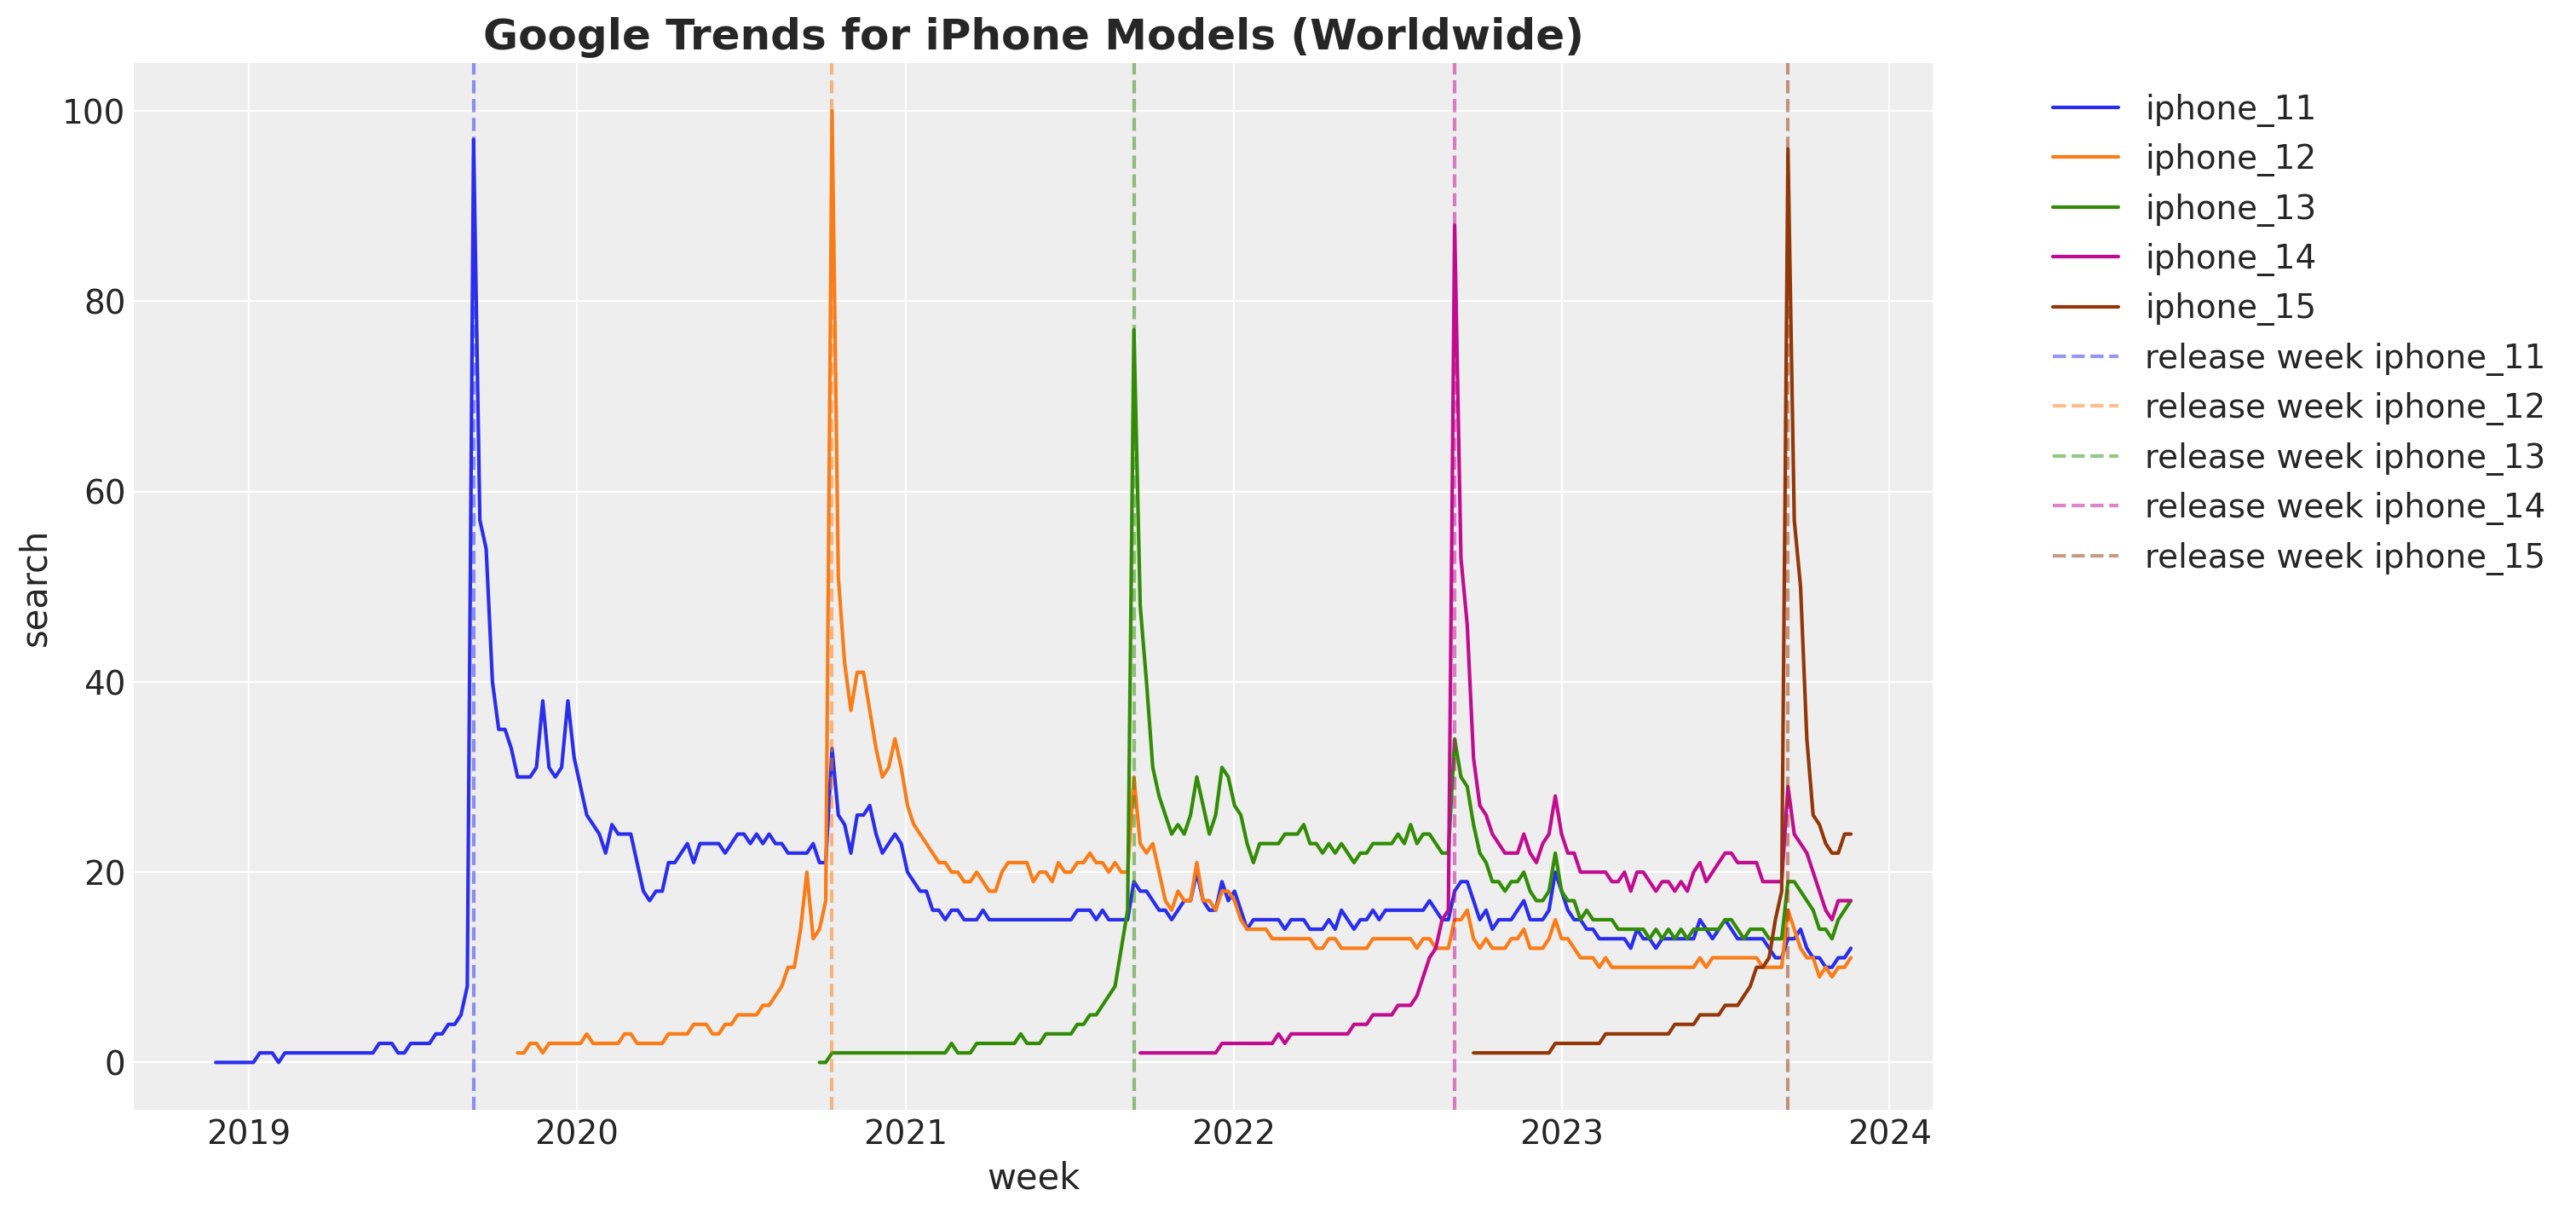

In [7]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.lineplot(
    data=data_df,
    x="week",
    y="search",
    hue="model",
    ax=ax,
)

for i, model in enumerate(release_dates_df["model"]):
    release_week = release_dates_df.query(f"model == '{model}'")["release_week"].item()
    ax.axvline(
        release_week,
        color=f"C{i}",
        linestyle="--",
        alpha=0.5,
        label=f"release week {model}",
    )

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_title(
    label="Google Trends for iPhone Models (Worldwide)", fontsize=18, fontweight="bold"
)

We do see how the peak maximum coincides with the release date.

Note that all of the models have a similar structure, however the maximum and decay forms differ from model to model. This motivates the use of a hierarchical model.

On the other hand, if we plot the search index in a heat map we doo see the immediate similarity to th cohort analysis problem where we use `age` and `cohort` age as key futures to model the revenue and retention:

<Axes: xlabel='week', ylabel='model'>

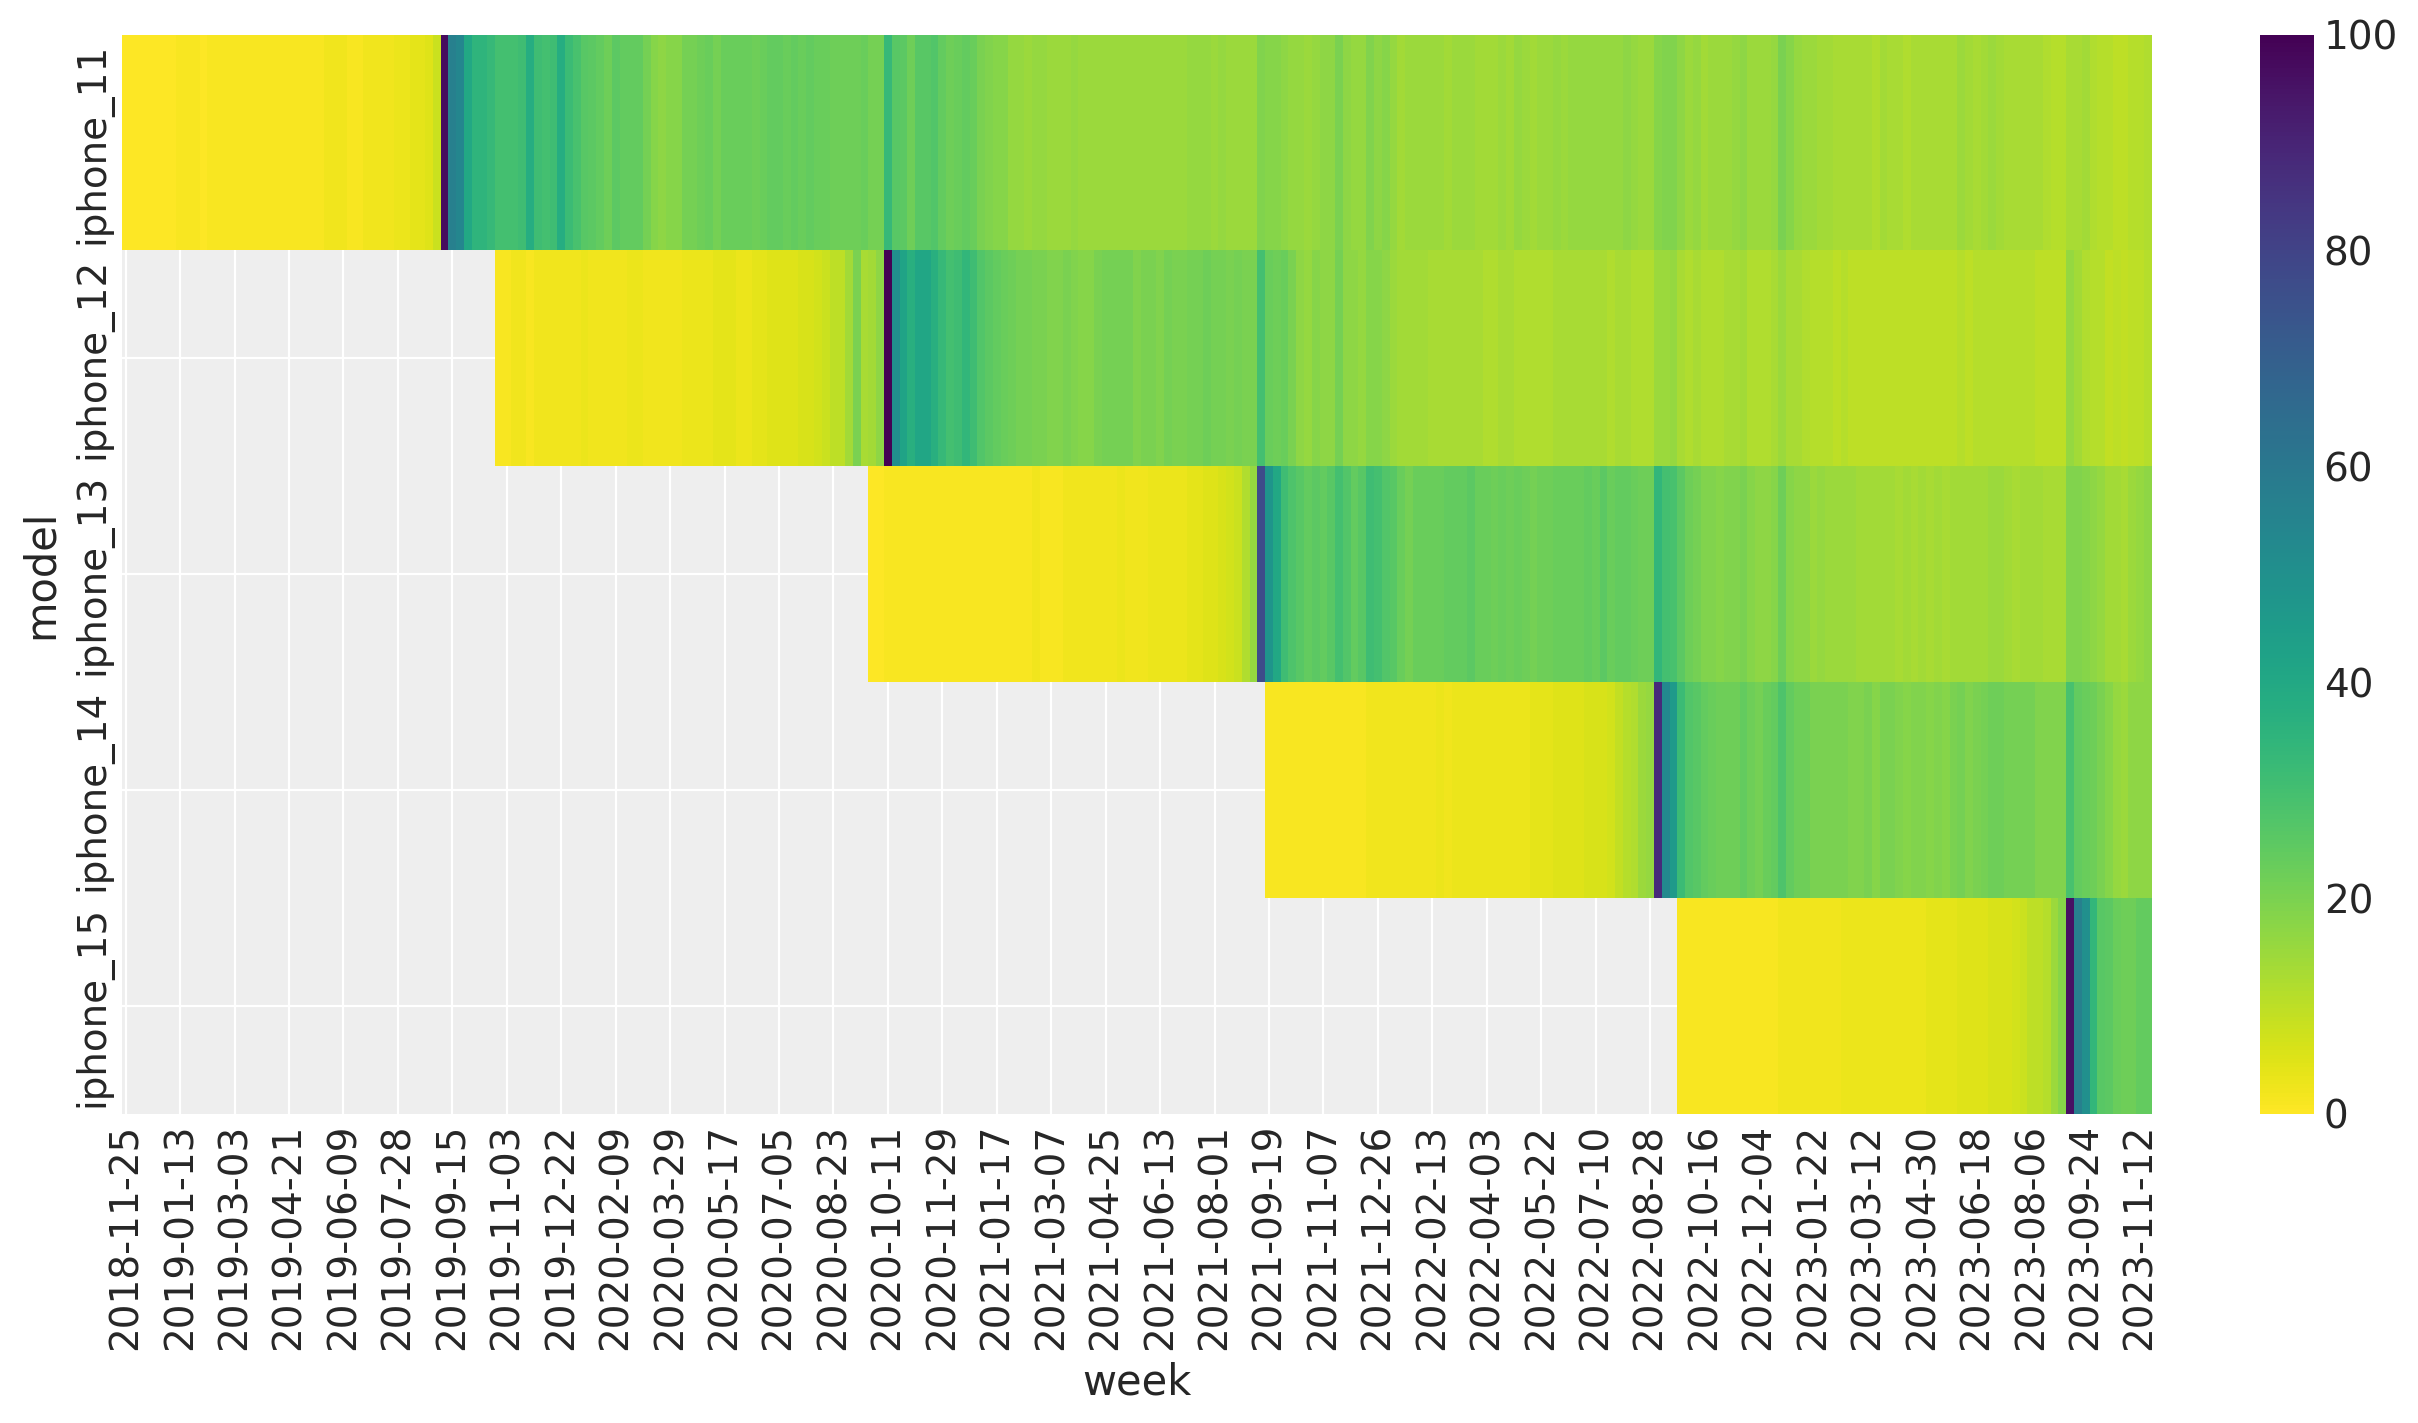

In [8]:
fig, ax = plt.subplots()
(
    data_df.assign(week=lambda x: x["week"].dt.date)[["model", "week", "search"]]
    .pivot_table(index="model", columns="week", values="search")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        ax=ax,
    )
)

This motivates the use of BART as a non-parametric component to model seasonal and long term behavior of the search index.

**Remark:** This is of course not the only possibility. We could for example use (hierarchical) Gaussian processes.

## Prepare Data

We now prepare the data for the model.

In [9]:
# model for the holdout data
test_model = "iphone_15"

train_df = data_df.query(f"model != '{test_model}'")
test_df = data_df.query(f"model == '{test_model}'")

In [10]:
train_obs = train_df.index.to_numpy()
train_iphone_model_idx, train_iphone_model = train_df["model"].factorize(sort=True)
train_month_idx, train_month = train_df["month"].factorize(sort=True)
train_age = train_df["age"].to_numpy()
train_model_age = train_df["model_age"].to_numpy()
train_is_release = train_df["is_release"].to_numpy()
x_train = train_df[["age", "model_age", "month"]]
train_search = train_df["search"].to_numpy()

## Model Specification

### Main Idea

The main idea is to model the search index through a negative binomial likelihood where the mean is the sum of the release phase plus the long term decay. For the release phase we use a non-symmetric [Gaussian bump function](https://juanitorduz.github.io/bump_func/) while for the long term decay we use a BART model.

**Remark**: We use the recommended parametrization for the negative binomial distribution, see [here](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations#story-when-the-generic-prior-fails-the-case-of-the-negative-binomial).

**Remark:** We weight the $\alpha$ parameter in the likelihood to place more importance on the search index values closer to the release date. The motivation is that we are often interested in this first phase much more than the relatively stable decay (see [here](https://discourse.pymc.io/t/how-to-add-weights-to-data-in-bayesian-linear-regression/8362)).

### Mathematical Formulation

Here are the main ingredients of the model:

$$
\begin{align*}
\beta^{[m]}_{\text{release}} & \sim \text{HalfNormal}(\sigma_{\beta}) \\
\ell^{[m]}_{\pm} & \sim \text{HalfNormal}(\sigma_{\ell}) \\
\mu_{\text{release}} & = \beta^{[m]}_{\text{release}} \left( I\{\text{model\_age} \leq 0\} \exp(-{\text{model\_age}^{p_{-}} / \ell^{[m]}_{-}}) + I\{\text{model\_age} \geq 0\} \exp(-{\text{model\_age}^{p_{+}} / \ell^{[m]}_{+}} )  \right)\\
\mu_{\text{decay}} & = \text{BART}(\text{age}, \text{model\_age}, \text{month}) \\
\mu & = \mu_{\text{release}} + \mu_{\text{decay}} \\
\alpha & = \frac{1}{\sqrt{\tilde{\alpha}}} \\
\alpha_{\text{weighted}} & = \frac{\alpha}{|\text{model\_age}|} \\
\text{search} & \sim \text{NegativeBinomial}(\mu, \alpha_{\text{weighted}})
\end{align*}
$$

The hierarchical structure is encoded in $\beta{\text{release}}$ and the  $\ell_{\pm}$ which come from a common prior for each model respectively.

I believe this mathematical formulation is not very intuitive, so let's go to the PyMC code:

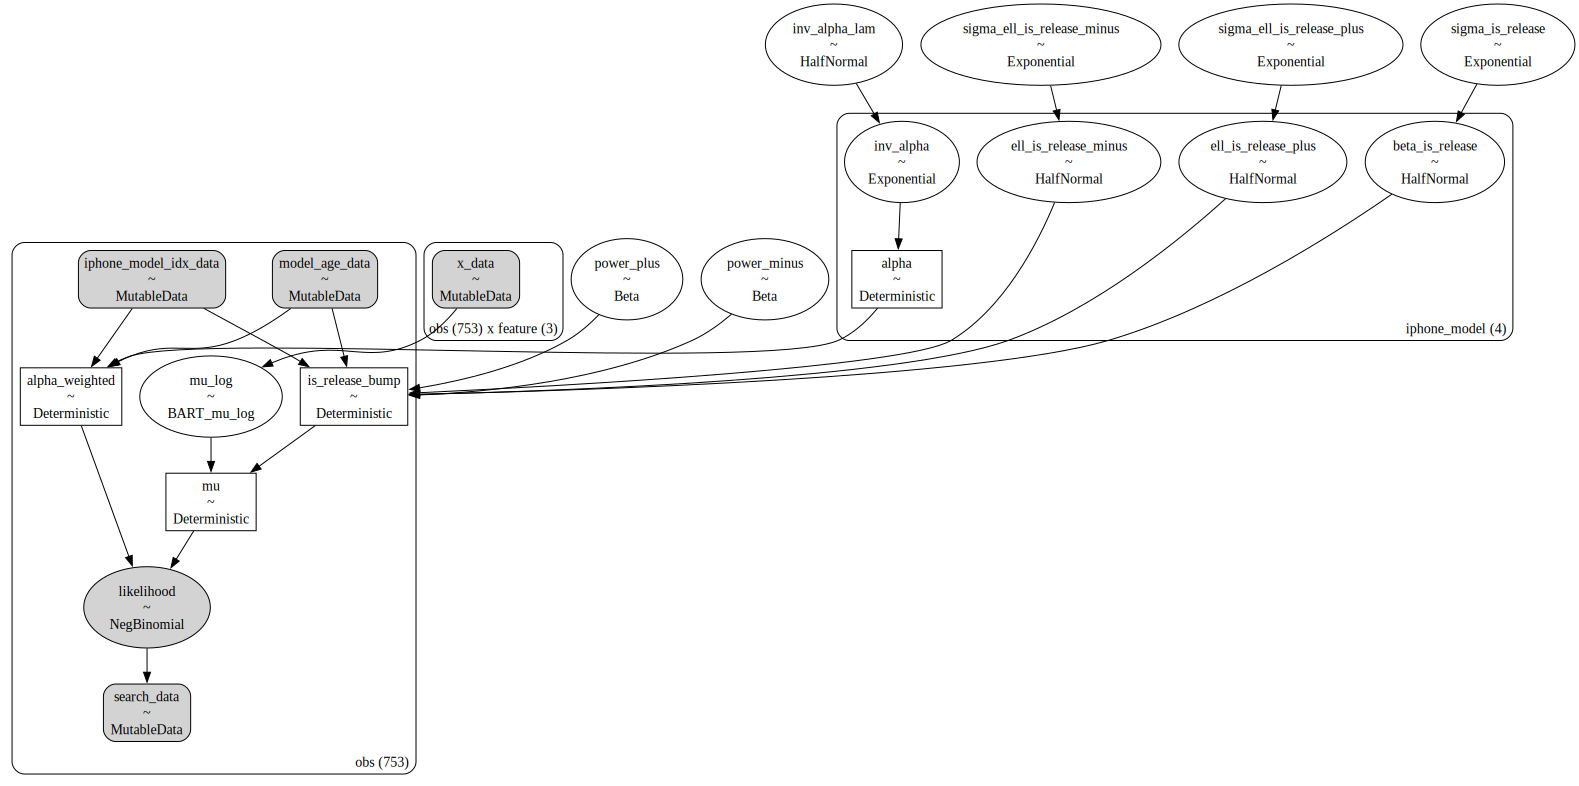

In [11]:
# small number for numerical stability
eps = np.finfo(float).eps

coords = {
    "month": train_month,
    "feature": x_train.columns,
}

with pm.Model(coords=coords) as model:
    # --- Data Containers ---

    model.add_coord(name="iphone_model", values=train_iphone_model, mutable=True)
    model.add_coord(name="obs", values=train_obs, mutable=True)
    iphone_model_idx_data = pm.MutableData(
        name="iphone_model_idx_data", value=train_iphone_model_idx, dims="obs"
    )
    model_age_data = pm.MutableData(
        name="model_age_data", value=train_model_age, dims="obs"
    )
    x_data = pm.MutableData(name="x_data", value=x_train, dims=("obs", "feature"))
    search_data = pm.MutableData(name="search_data", value=train_search, dims="obs")

    # --- Priors ---

    power_minus = pm.Beta(name="power_minus", alpha=5, beta=15)
    power_plus = pm.Beta(name="power_plus", alpha=5, beta=15)

    sigma_ell_is_release_minus = pm.Exponential(
        name="sigma_ell_is_release_minus", lam=1
    )
    sigma_ell_is_release_plus = pm.Exponential(
        name="sigma_ell_is_release_plus", lam=1 / 4
    )
    sigma_is_release = pm.Exponential(name="sigma_is_release", lam=1 / 100)

    ell_is_release_minus = pm.HalfNormal(
        name="ell_is_release_minus",
        sigma=sigma_ell_is_release_minus,
        dims="iphone_model",
    )

    ell_is_release_plus = pm.HalfNormal(
        name="ell_is_release_plus", sigma=sigma_ell_is_release_plus, dims="iphone_model"
    )

    beta_is_release = pm.HalfNormal(
        name="beta_is_release", sigma=sigma_is_release, dims="iphone_model"
    )

    inv_alpha_lam = pm.HalfNormal(name="inv_alpha_lam", sigma=200)

    inv_alpha = pm.Exponential(name="inv_alpha", lam=inv_alpha_lam, dims="iphone_model")

    bart_mu_log = pmb.BART(
        name="mu_log",
        X=x_data,
        Y=np.log1p(train_search),
        m=50,
        split_rules=[
            ContinuousSplitRule(),
            ContinuousSplitRule(),
            SubsetSplitRule(),
        ],
        dims="obs",
    )

    # --- Parametrization ---

    is_release_bump = pm.Deterministic(
        name="is_release_bump",
        var=beta_is_release[iphone_model_idx_data]
        * (
            (
                (model_age_data < 0)
                * pt.exp(
                    -pt.pow(pt.abs(model_age_data), power_minus)
                    / ell_is_release_minus[iphone_model_idx_data]
                )
            )
            + (
                (model_age_data >= 0)
                * pt.exp(
                    -pt.pow(pt.abs(model_age_data), power_plus)
                    / ell_is_release_plus[iphone_model_idx_data]
                )
            )
        ),
        dims="obs",
    )

    mu = pm.Deterministic(
        name="mu",
        var=pt.exp(bart_mu_log) + is_release_bump,
        dims="obs",
    )

    alpha = pm.Deterministic(
        name="alpha",
        var=1 / (pt.sqrt(inv_alpha) + eps),
        dims="iphone_model",
    )

    alpha_weighted = pm.Deterministic(
        name="alpha_weighted",
        var=alpha[iphone_model_idx_data] / (pt.abs(model_age_data) + 1),
        dims="obs",
    )

    # --- Likelihood ---

    _ = pm.NegativeBinomial(
        name="likelihood",
        mu=mu,
        alpha=alpha_weighted,
        observed=search_data,
        dims="obs",
    )

pm.model_to_graphviz(model=model)

We can take a look into some of the prior distributions for the Gaussian bump parameters:

Text(0.5, 1.0, '$\\sigma_{\\ell}$')

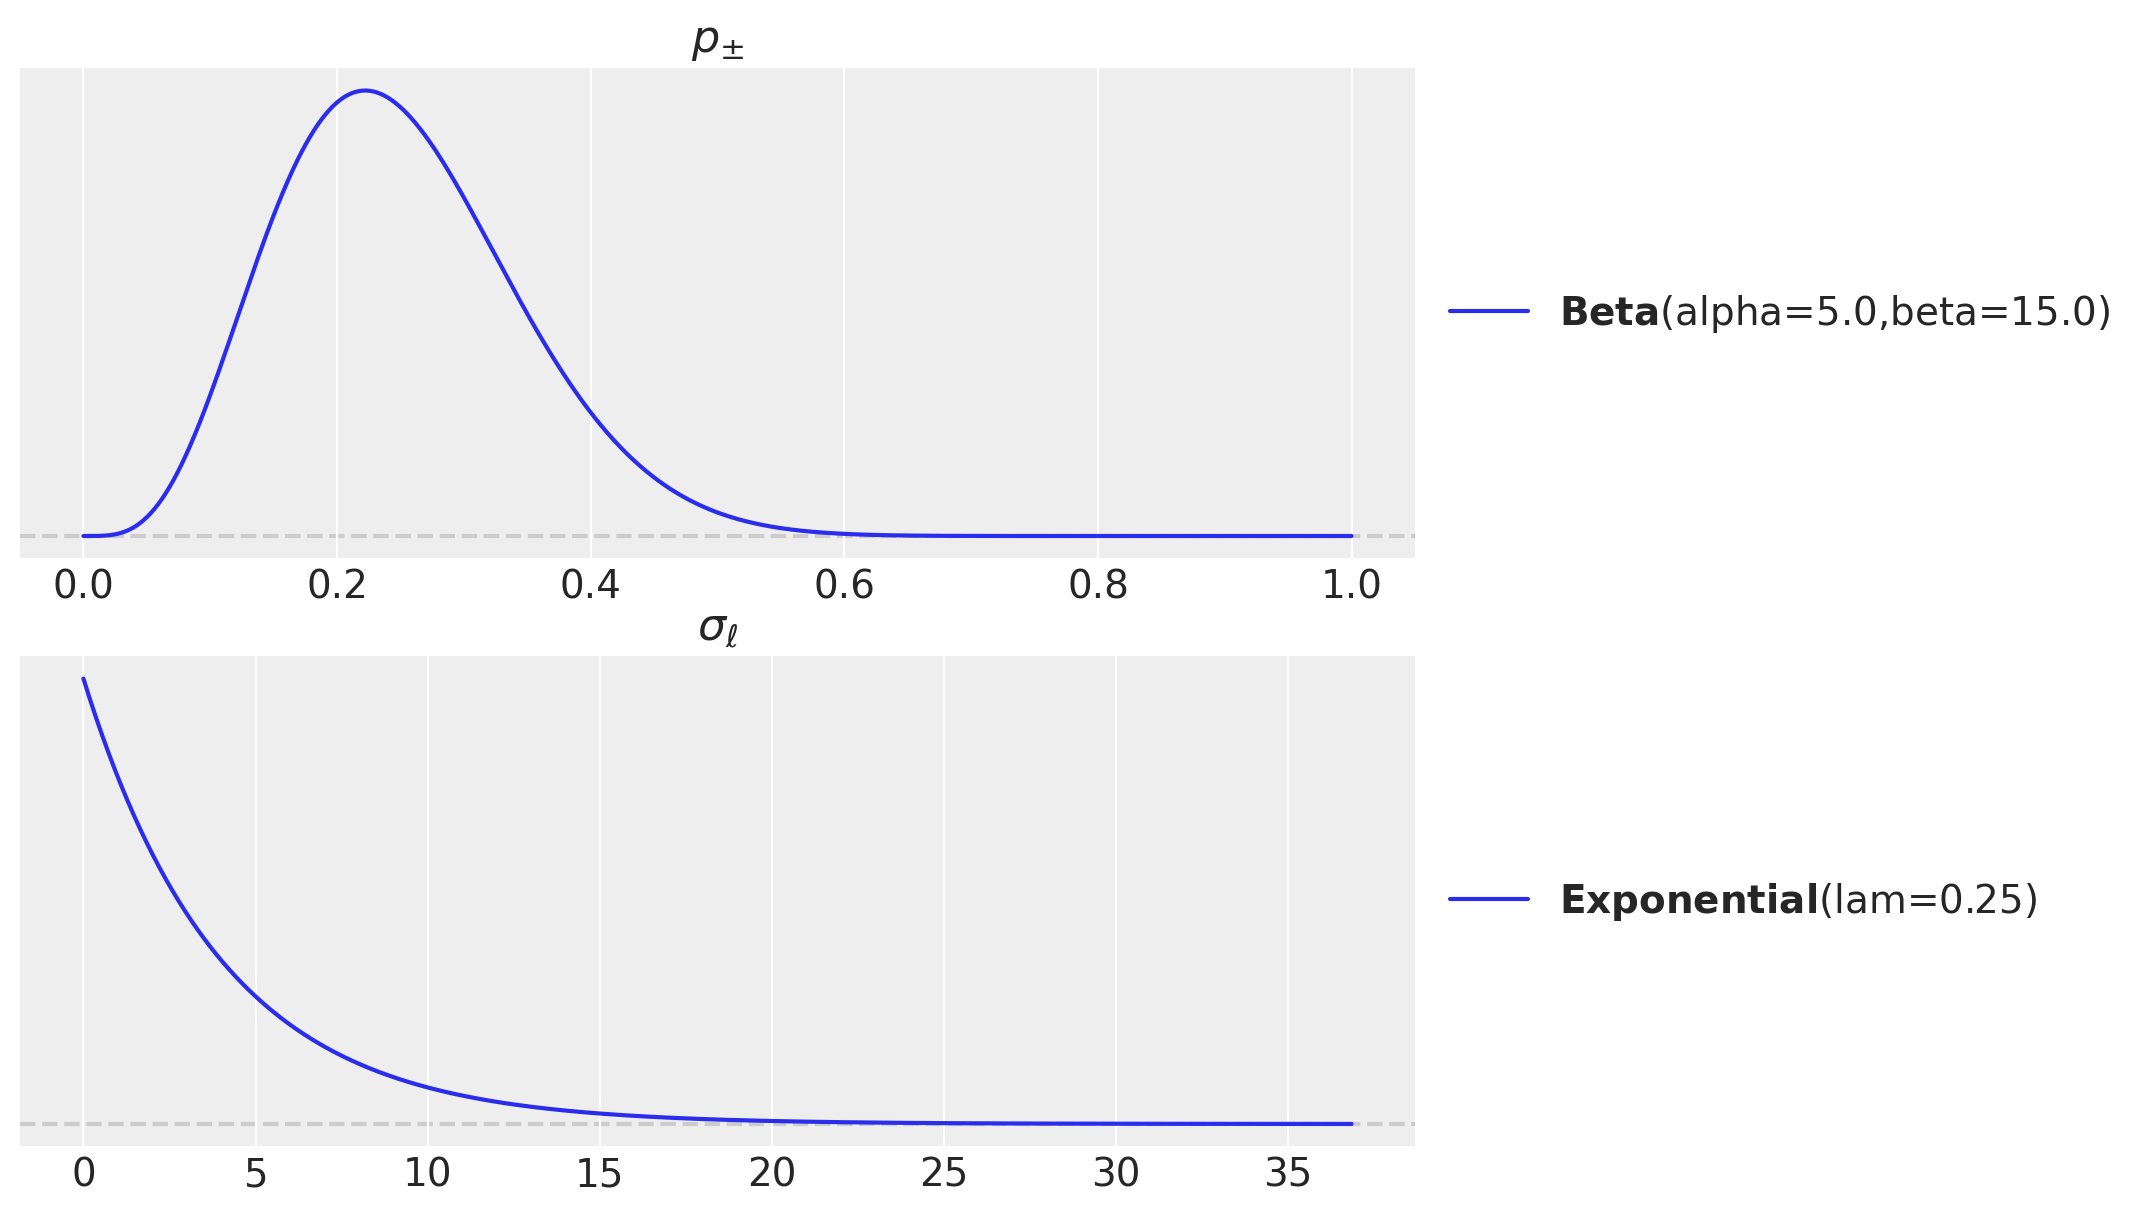

In [12]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(9, 7), sharex=False, sharey=False, layout="constrained"
)
pz.Beta(alpha=5, beta=15).plot_pdf(ax=ax[0])
ax[0].set_title(r"$p_{\pm}$")
pz.Exponential(lam=1 / 4).plot_pdf(ax=ax[1])
ax[1].set_title(r"$\sigma_{\ell}$")

## Prior Predictive

Let's start with the prior predictive distribution to check the feasibility of the priors and the model specification:

In [13]:
with model:
    prior_predictive = pm.sample_prior_predictive(samples=1_000, random_seed=rng)

Sampling: [beta_is_release, ell_is_release_minus, ell_is_release_plus, inv_alpha, inv_alpha_lam, likelihood, mu_log, power_minus, power_plus, sigma_ell_is_release_minus, sigma_ell_is_release_plus, sigma_is_release]


[None]

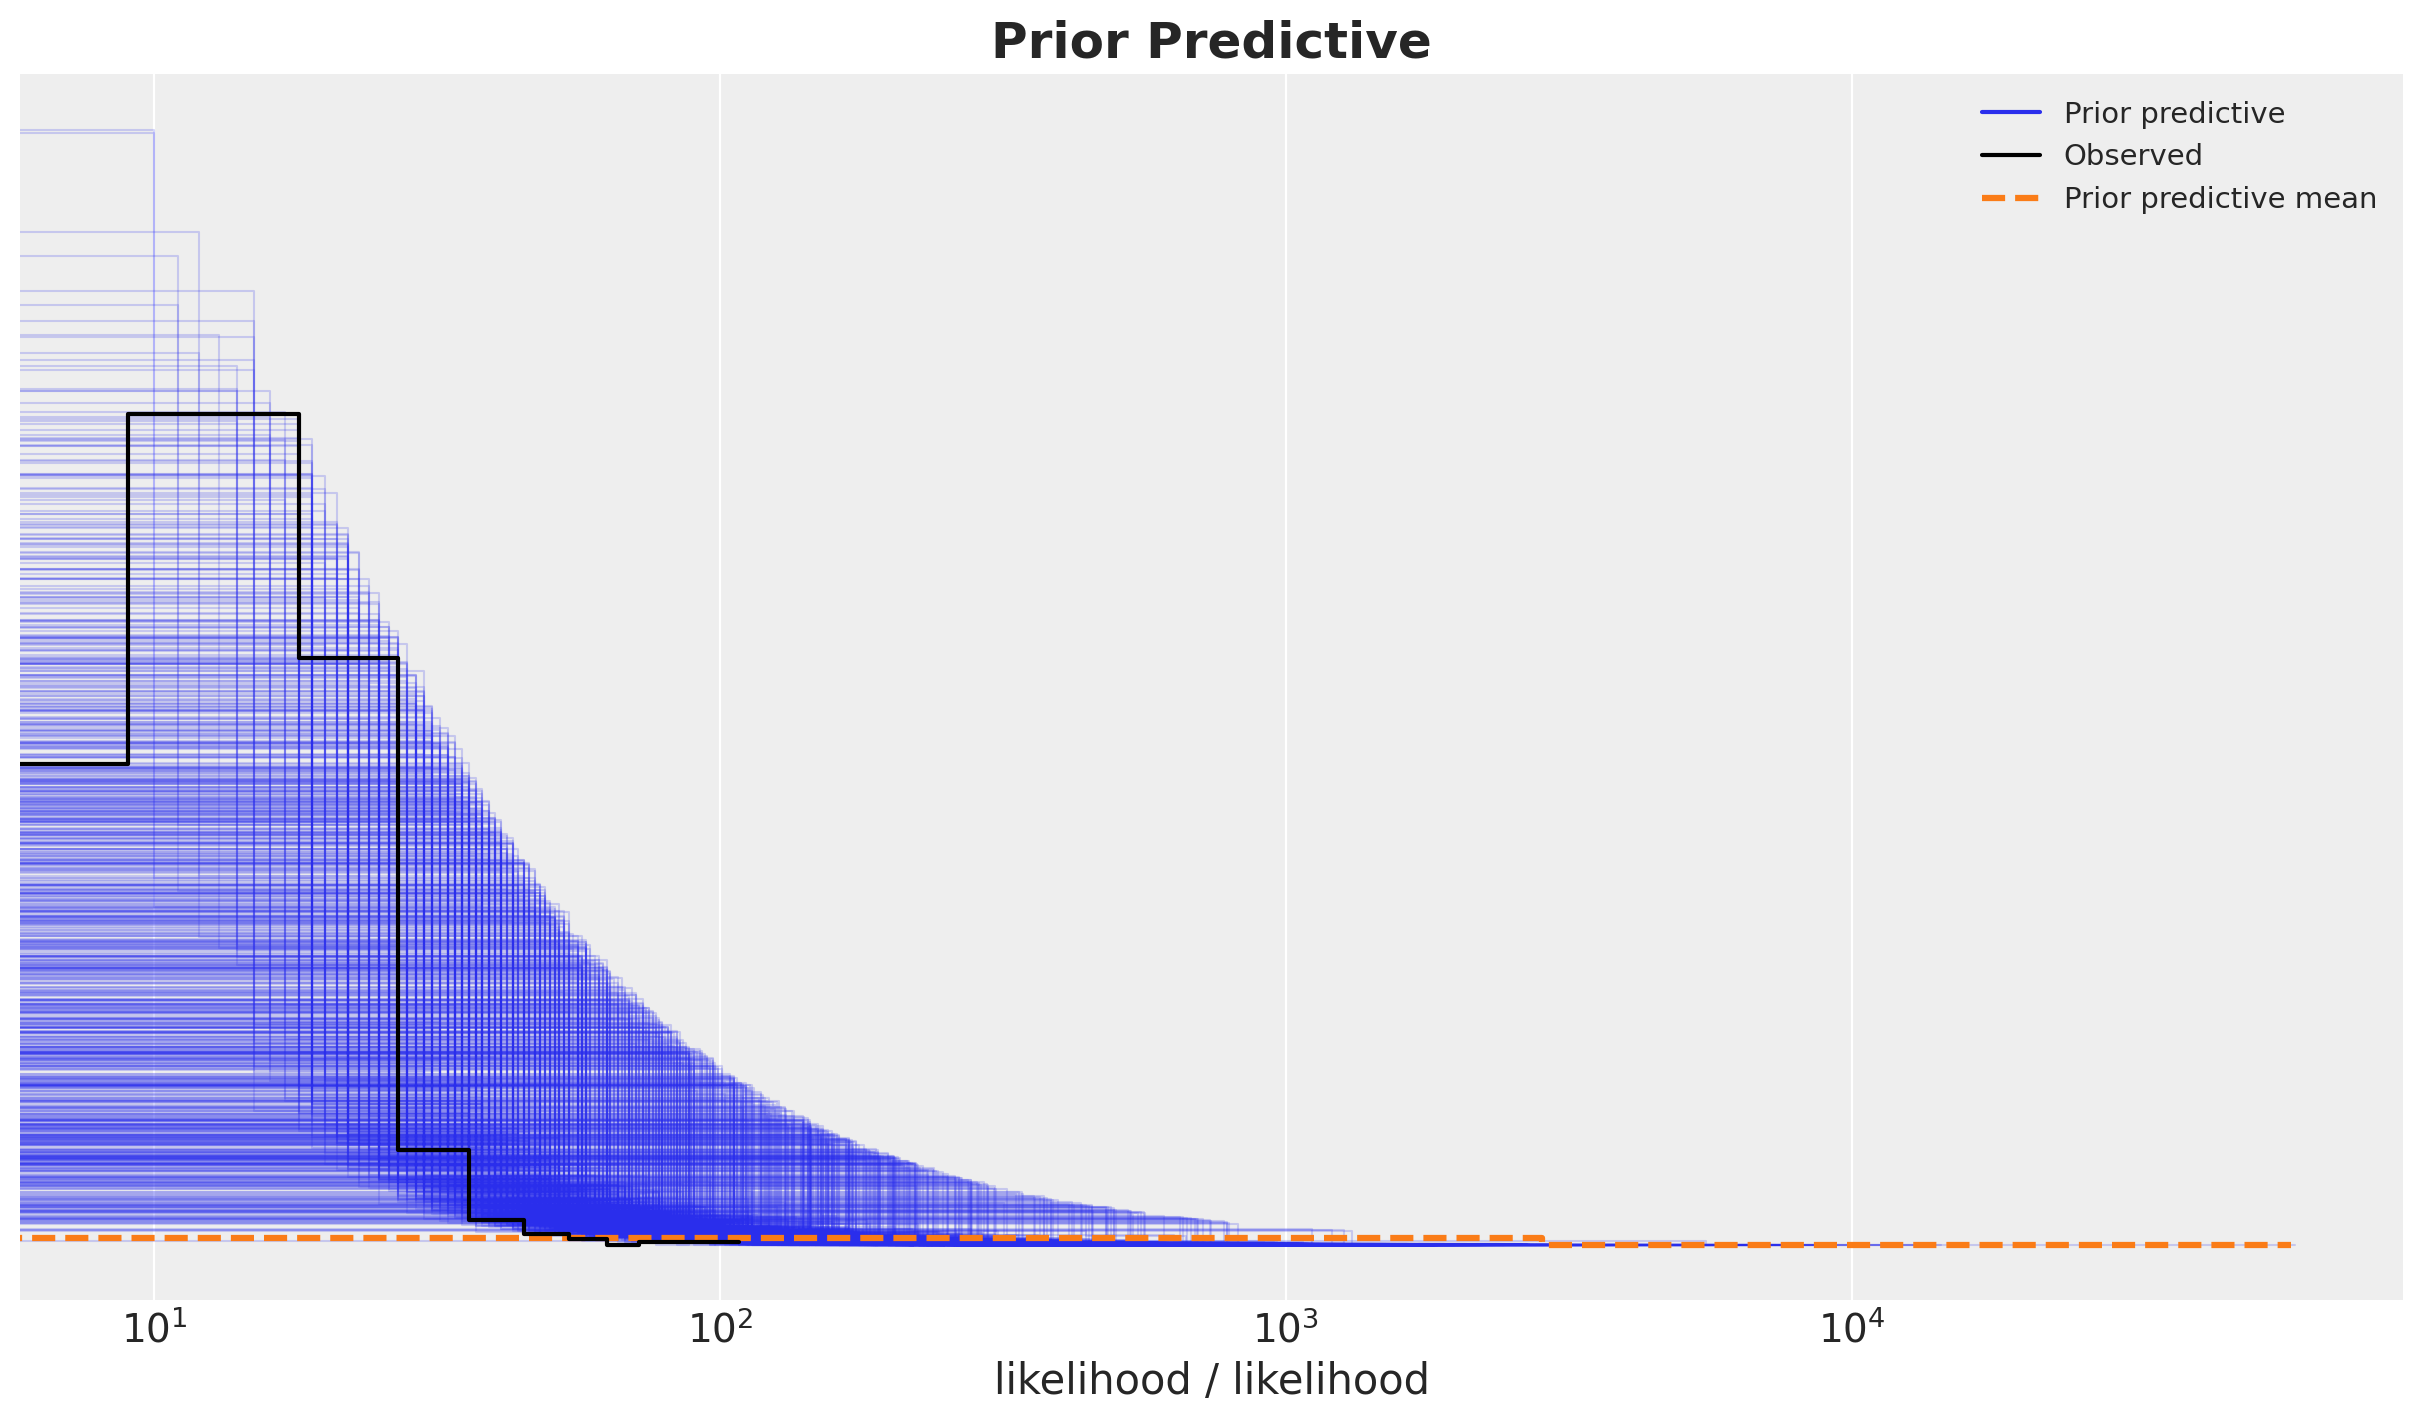

In [16]:
fig, ax = plt.subplots()
az.plot_ppc(data=prior_predictive, group="prior", kind="kde", ax=ax)
ax.set_title(label="Prior Predictive", fontsize=18, fontweight="bold")
ax.set(xscale="log")

Overall the prior predictive looks reasonable.

## Model Fitting

The model takes around $8$ minutes to fit (Mac Book Pro, Intel Core i7).

In [17]:
with model:
    idata = pm.sample(
        target_accept=0.95,
        draws=3_000,
        chains=4,
        random_seed=rng,
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata, random_seed=rng)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [power_minus, power_plus, sigma_ell_is_release_minus, sigma_ell_is_release_plus, sigma_is_release, ell_is_release_minus, ell_is_release_plus, beta_is_release, inv_alpha_lam, inv_alpha]
>PGBART: [mu_log]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 546 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


## Diagnostics

In [18]:
idata["sample_stats"]["diverging"].sum().item()

0

In [19]:
var_names = [
    "power_minus",
    "power_plus",
    "sigma_is_release",
    "sigma_ell_is_release_minus",
    "sigma_ell_is_release_plus",
    "beta_is_release",
    "ell_is_release_minus",
    "ell_is_release_plus",
    "inv_alpha_lam",
    "inv_alpha",
    "alpha",
]

az.summary(data=idata, var_names=var_names, round_to=3)

mean          sd     hdi_3%  \
power_minus                           0.290       0.030      0.234   
power_plus                            0.259       0.023      0.219   
sigma_is_release                    102.714      41.154     46.009   
sigma_ell_is_release_minus            0.669       0.305      0.265   
sigma_ell_is_release_plus             2.028       1.030      0.722   
beta_is_release[iphone_11]           88.664       7.601     74.587   
beta_is_release[iphone_12]          104.250       8.477     88.354   
beta_is_release[iphone_13]           70.825       6.822     58.417   
beta_is_release[iphone_14]           77.694       8.480     62.116   
ell_is_release_minus[iphone_11]       0.315       0.093      0.100   
ell_is_release_minus[iphone_12]       0.632       0.059      0.516   
ell_is_release_minus[iphone_13]       0.499       0.065      0.388   
ell_is_release_minus[iphone_14]       0.576       0.066      0.461   
ell_is_release_plus[iphone_11]        1.637       0.180      1.319   
ell_is_release_plus[iphone_12]        1.257       0.117      1.045   
ell_is_release_plus[iphone_13]        1.676       0.177      1.359   
ell_is_release_plus[iphone_14]        1.426       0.164      1.126   
inv_alpha_lam                       424.888     139.224    174.110   
inv_alpha[iphone_11]                  0.000       0.000      0.000   
inv_alpha[iphone_12]                  0.000       0.000      0.000   
inv_alpha[iphone_13]                  0.000       0.000      0.000   
inv_alpha[iphone_14]                  0.000       0.000      0.000   
alpha[iphone_11]                 145432.163  254014.908  15616.950   
alpha[iphone_12]                  69123.095  104183.013   6087.510   
alpha[iphone_13]                  41436.323   70211.987   3624.377   
alpha[iphone_14]                  15011.444   31521.554   1354.052   

                                    hdi_97%  mcse_mean   mcse_sd   ess_bulk  \
power_minus                           0.348      0.001     0.001   1671.787   
power_plus                            0.305      0.003     0.002     43.288   
sigma_is_release                    177.733      0.381     0.300  17272.859   
sigma_ell_is_release_minus            1.219      0.004     0.003   6680.975   
sigma_ell_is_release_plus             3.663      0.012     0.008  10303.069   
beta_is_release[iphone_11]          103.128      0.115     0.082   4281.135   
beta_is_release[iphone_12]          120.111      0.116     0.082   5293.617   
beta_is_release[iphone_13]           83.872      0.113     0.080   3588.316   
beta_is_release[iphone_14]           93.679      0.140     0.099   3626.175   
ell_is_release_minus[iphone_11]       0.451      0.004     0.003    701.170   
ell_is_release_minus[iphone_12]       0.740      0.002     0.001   1475.195   
ell_is_release_minus[iphone_13]       0.617      0.002     0.002   1104.827   
ell_is_release_minus[iphone_14]       0.705      0.002     0.001   1391.544   
ell_is_release_plus[iphone_11]        1.978      0.005     0.003   1525.015   
ell_is_release_plus[iphone_12]        1.479      0.003     0.002   1450.934   
ell_is_release_plus[iphone_13]        2.015      0.004     0.003   1778.066   
ell_is_release_plus[iphone_14]        1.729      0.004     0.003   1733.566   
inv_alpha_lam                       687.939      1.061     0.750  15560.562   
inv_alpha[iphone_11]                  0.000      0.000     0.000  14571.756   
inv_alpha[iphone_12]                  0.000      0.000     0.000  11596.181   
inv_alpha[iphone_13]                  0.000      0.000     0.000  12890.357   
inv_alpha[iphone_14]                  0.000      0.000     0.000  13082.315   
alpha[iphone_11]                 390326.703   2970.684  2100.675  14571.756   
alpha[iphone_12]                 178183.496   1507.258  1065.858  11596.181   
alpha[iphone_13]                 105970.380    979.158   692.409  12890.357   
alpha[iphone_14]                  38361.172    428.764   303.198  13082.315   

              

Text(0.5, 0.98, 'Model Trace')

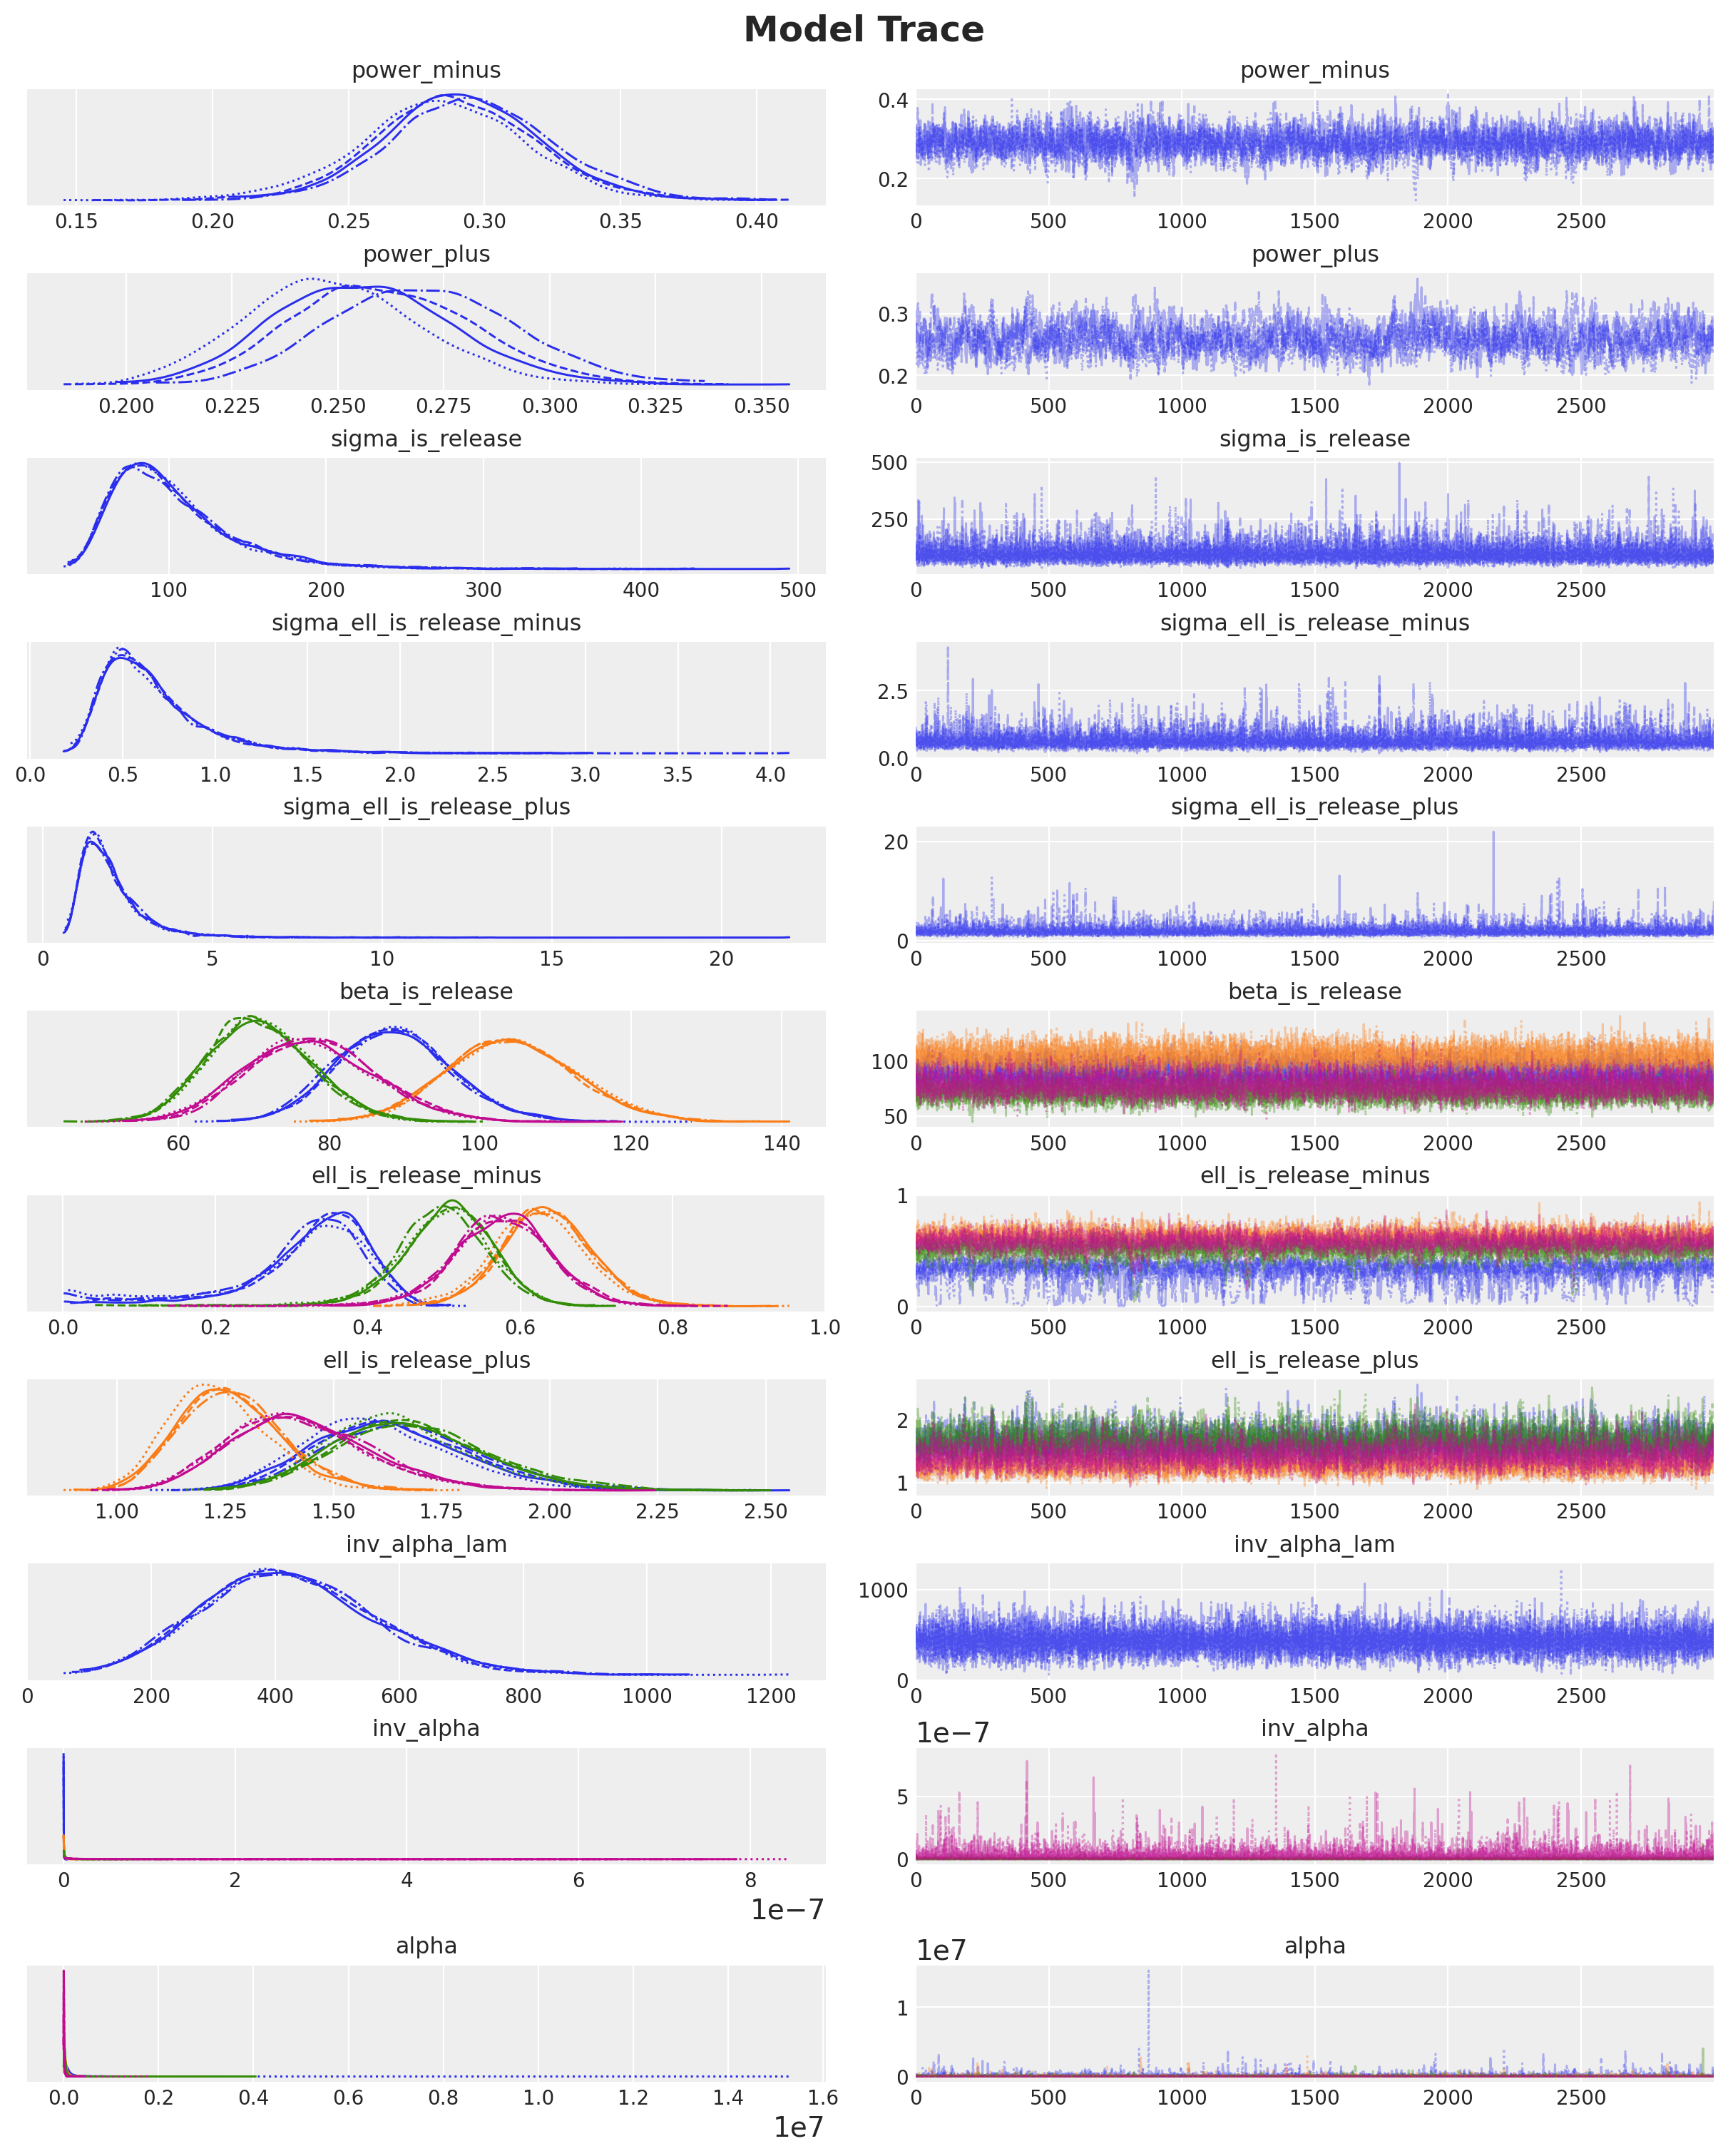

In [20]:
axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    compact=True,
    backend_kwargs={"figsize": (12, 15), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=18, fontweight="bold")

## Posterior Predictive

<Axes: xlabel='likelihood / likelihood'>

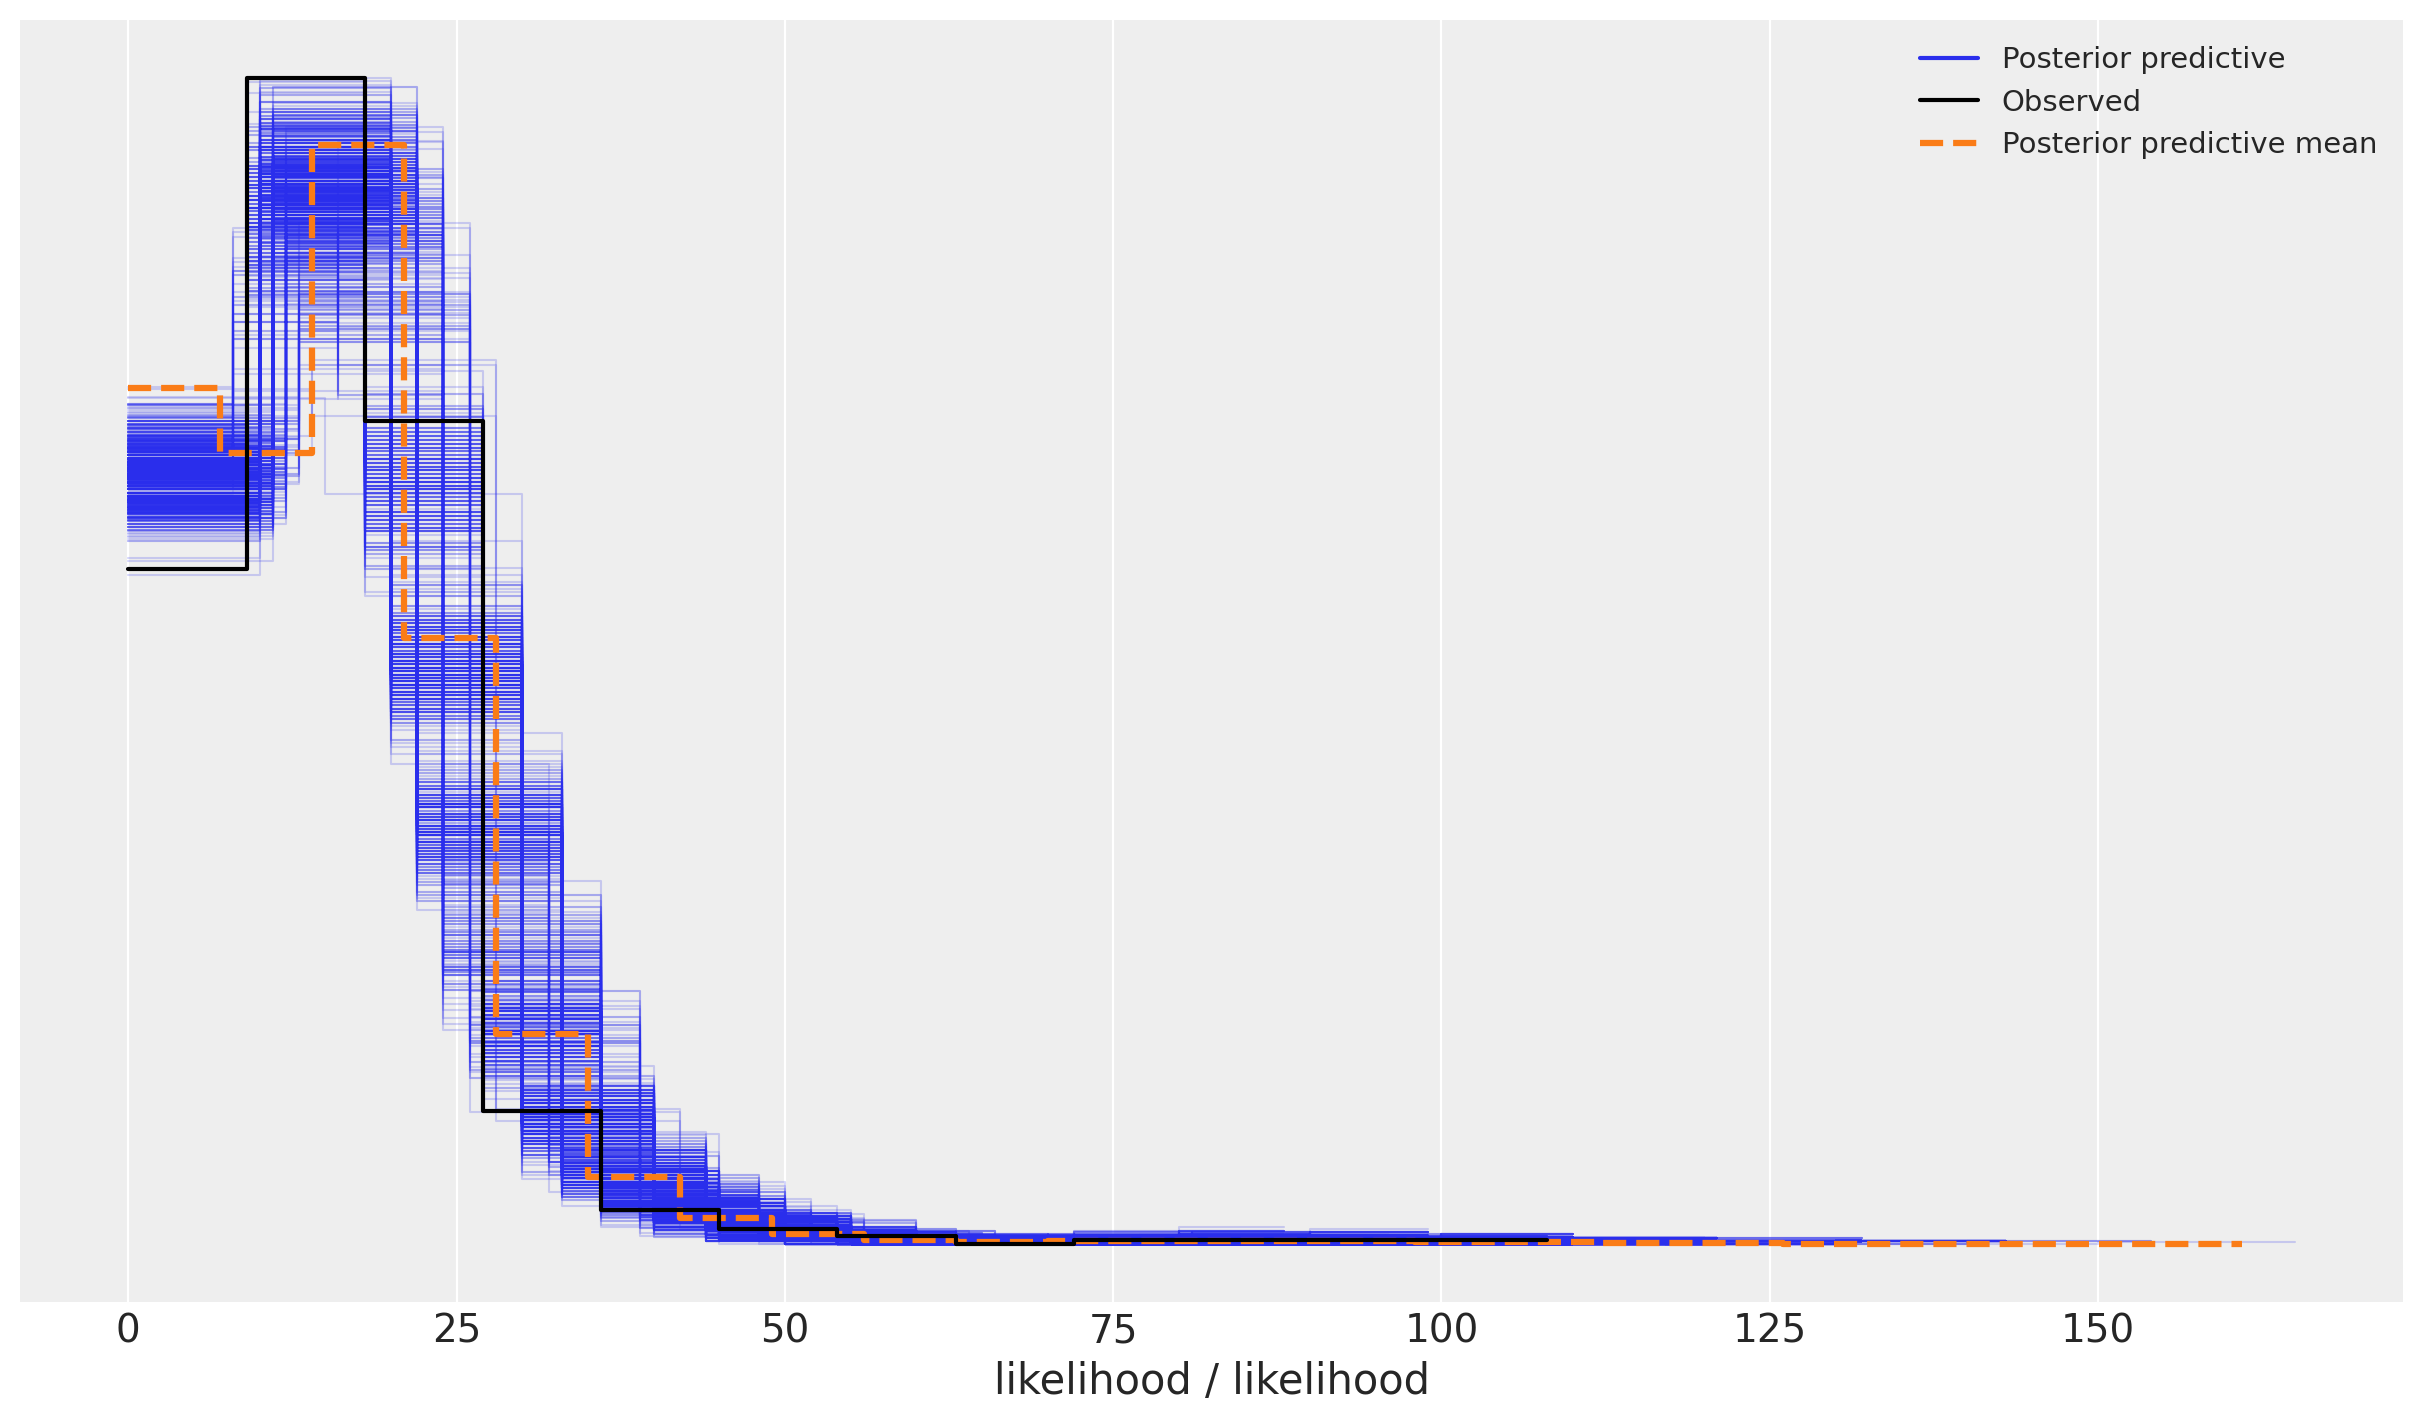

In [21]:
az.plot_ppc(
    data=posterior_predictive,
    num_pp_samples=1_000,
    observed_rug=True,
    random_seed=seed,
)

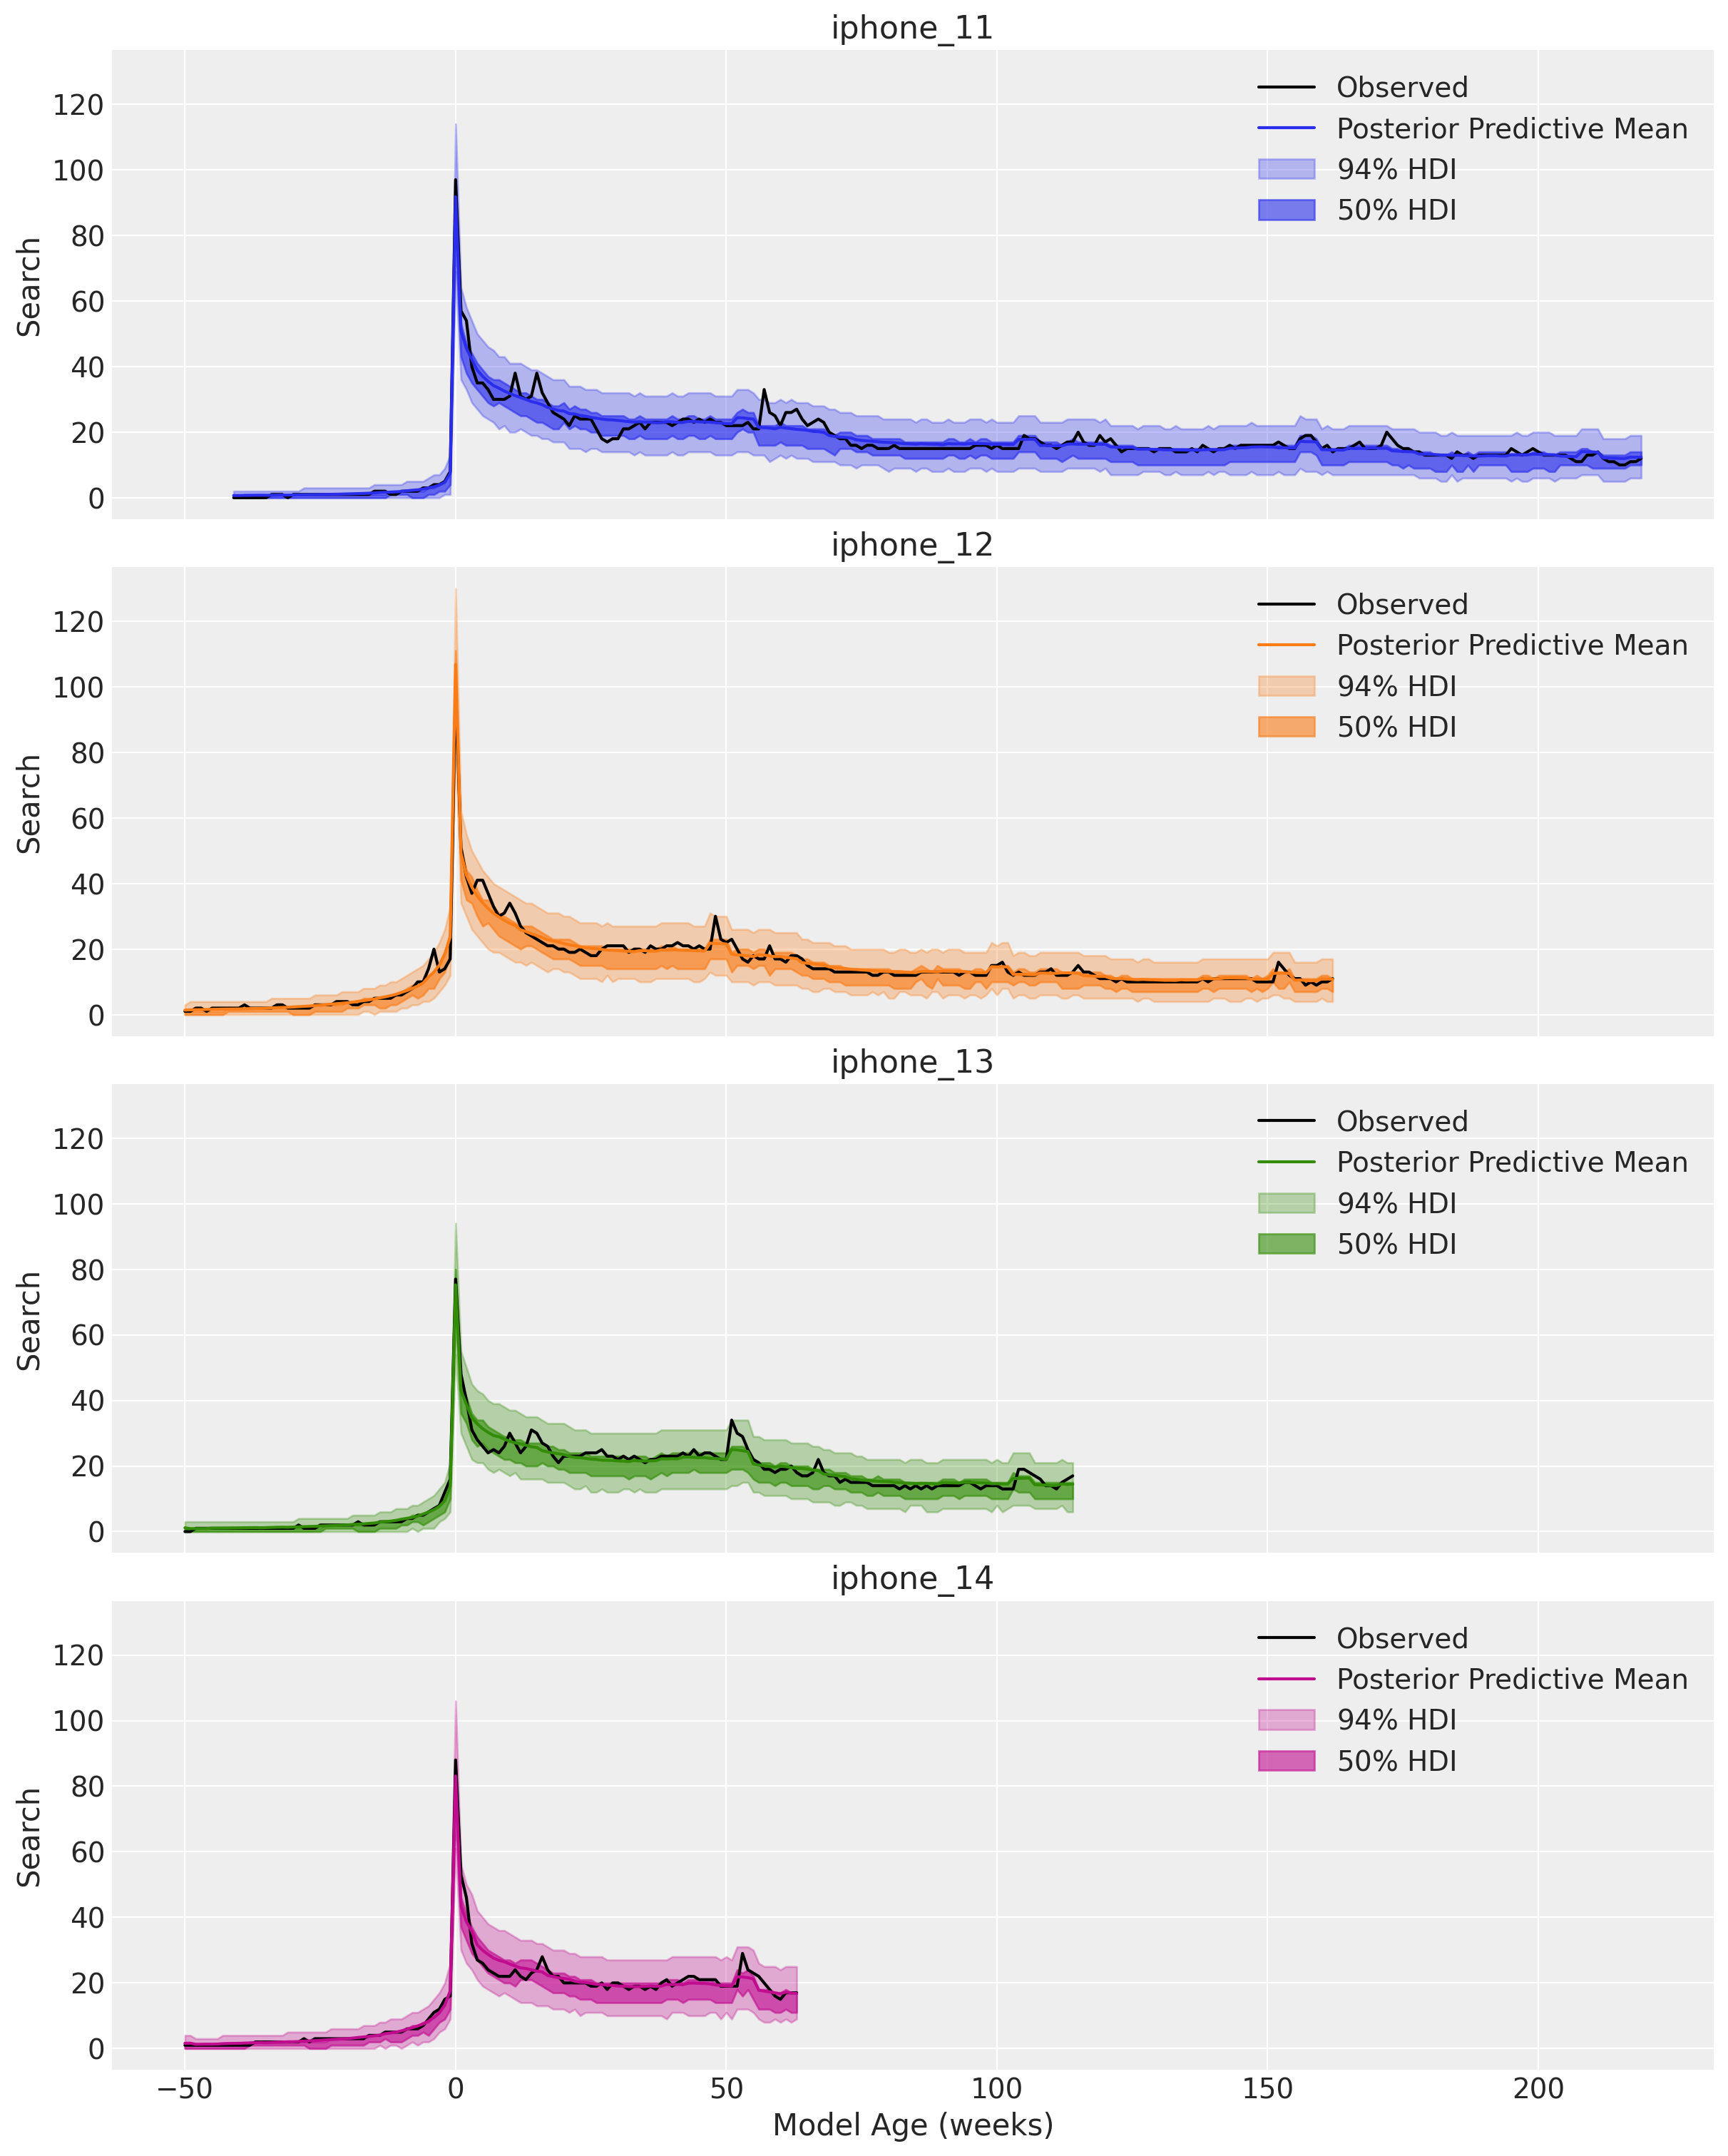

In [22]:
fig, axes = plt.subplots(
    nrows=train_iphone_model.size,
    ncols=1,
    sharex=True,
    sharey=True,
    figsize=(12, 15),
    layout="constrained",
)

for i, iphone_model in enumerate(train_iphone_model):
    ax = axes[i]

    condition = train_df["model"] == iphone_model
    temp_df = train_df[condition]
    temp_likelihood = posterior_predictive["posterior_predictive"]["likelihood"][
        :, :, condition.to_numpy()
    ]

    sns.lineplot(
        data=temp_df,
        x="model_age",
        y="search",
        color="black",
        label="Observed",
        ax=ax,
    )
    sns.lineplot(
        x=temp_df["model_age"],
        y=temp_likelihood.mean(dim=("chain", "draw")),
        color=f"C{i}",
        label="Posterior Predictive Mean",
        ax=ax,
    )
    az.plot_hdi(
        x=temp_df["model_age"],
        y=temp_likelihood,
        hdi_prob=0.94,
        color=f"C{i}",
        smooth=False,
        fill_kwargs={"alpha": 0.3, "label": r"$94\%$ HDI"},
        ax=ax,
    )
    az.plot_hdi(
        x=temp_df["model_age"],
        y=temp_likelihood,
        hdi_prob=0.50,
        color=f"C{i}",
        smooth=False,
        fill_kwargs={"alpha": 0.6, "label": r"$50\%$ HDI"},
        ax=ax,
    )
    ax.legend(loc="upper right")
    ax.set(title=iphone_model, xlabel="Model Age (weeks)", ylabel="Search")

Text(0.5, 1.05, 'Partial Dependency Plots (PDP)')

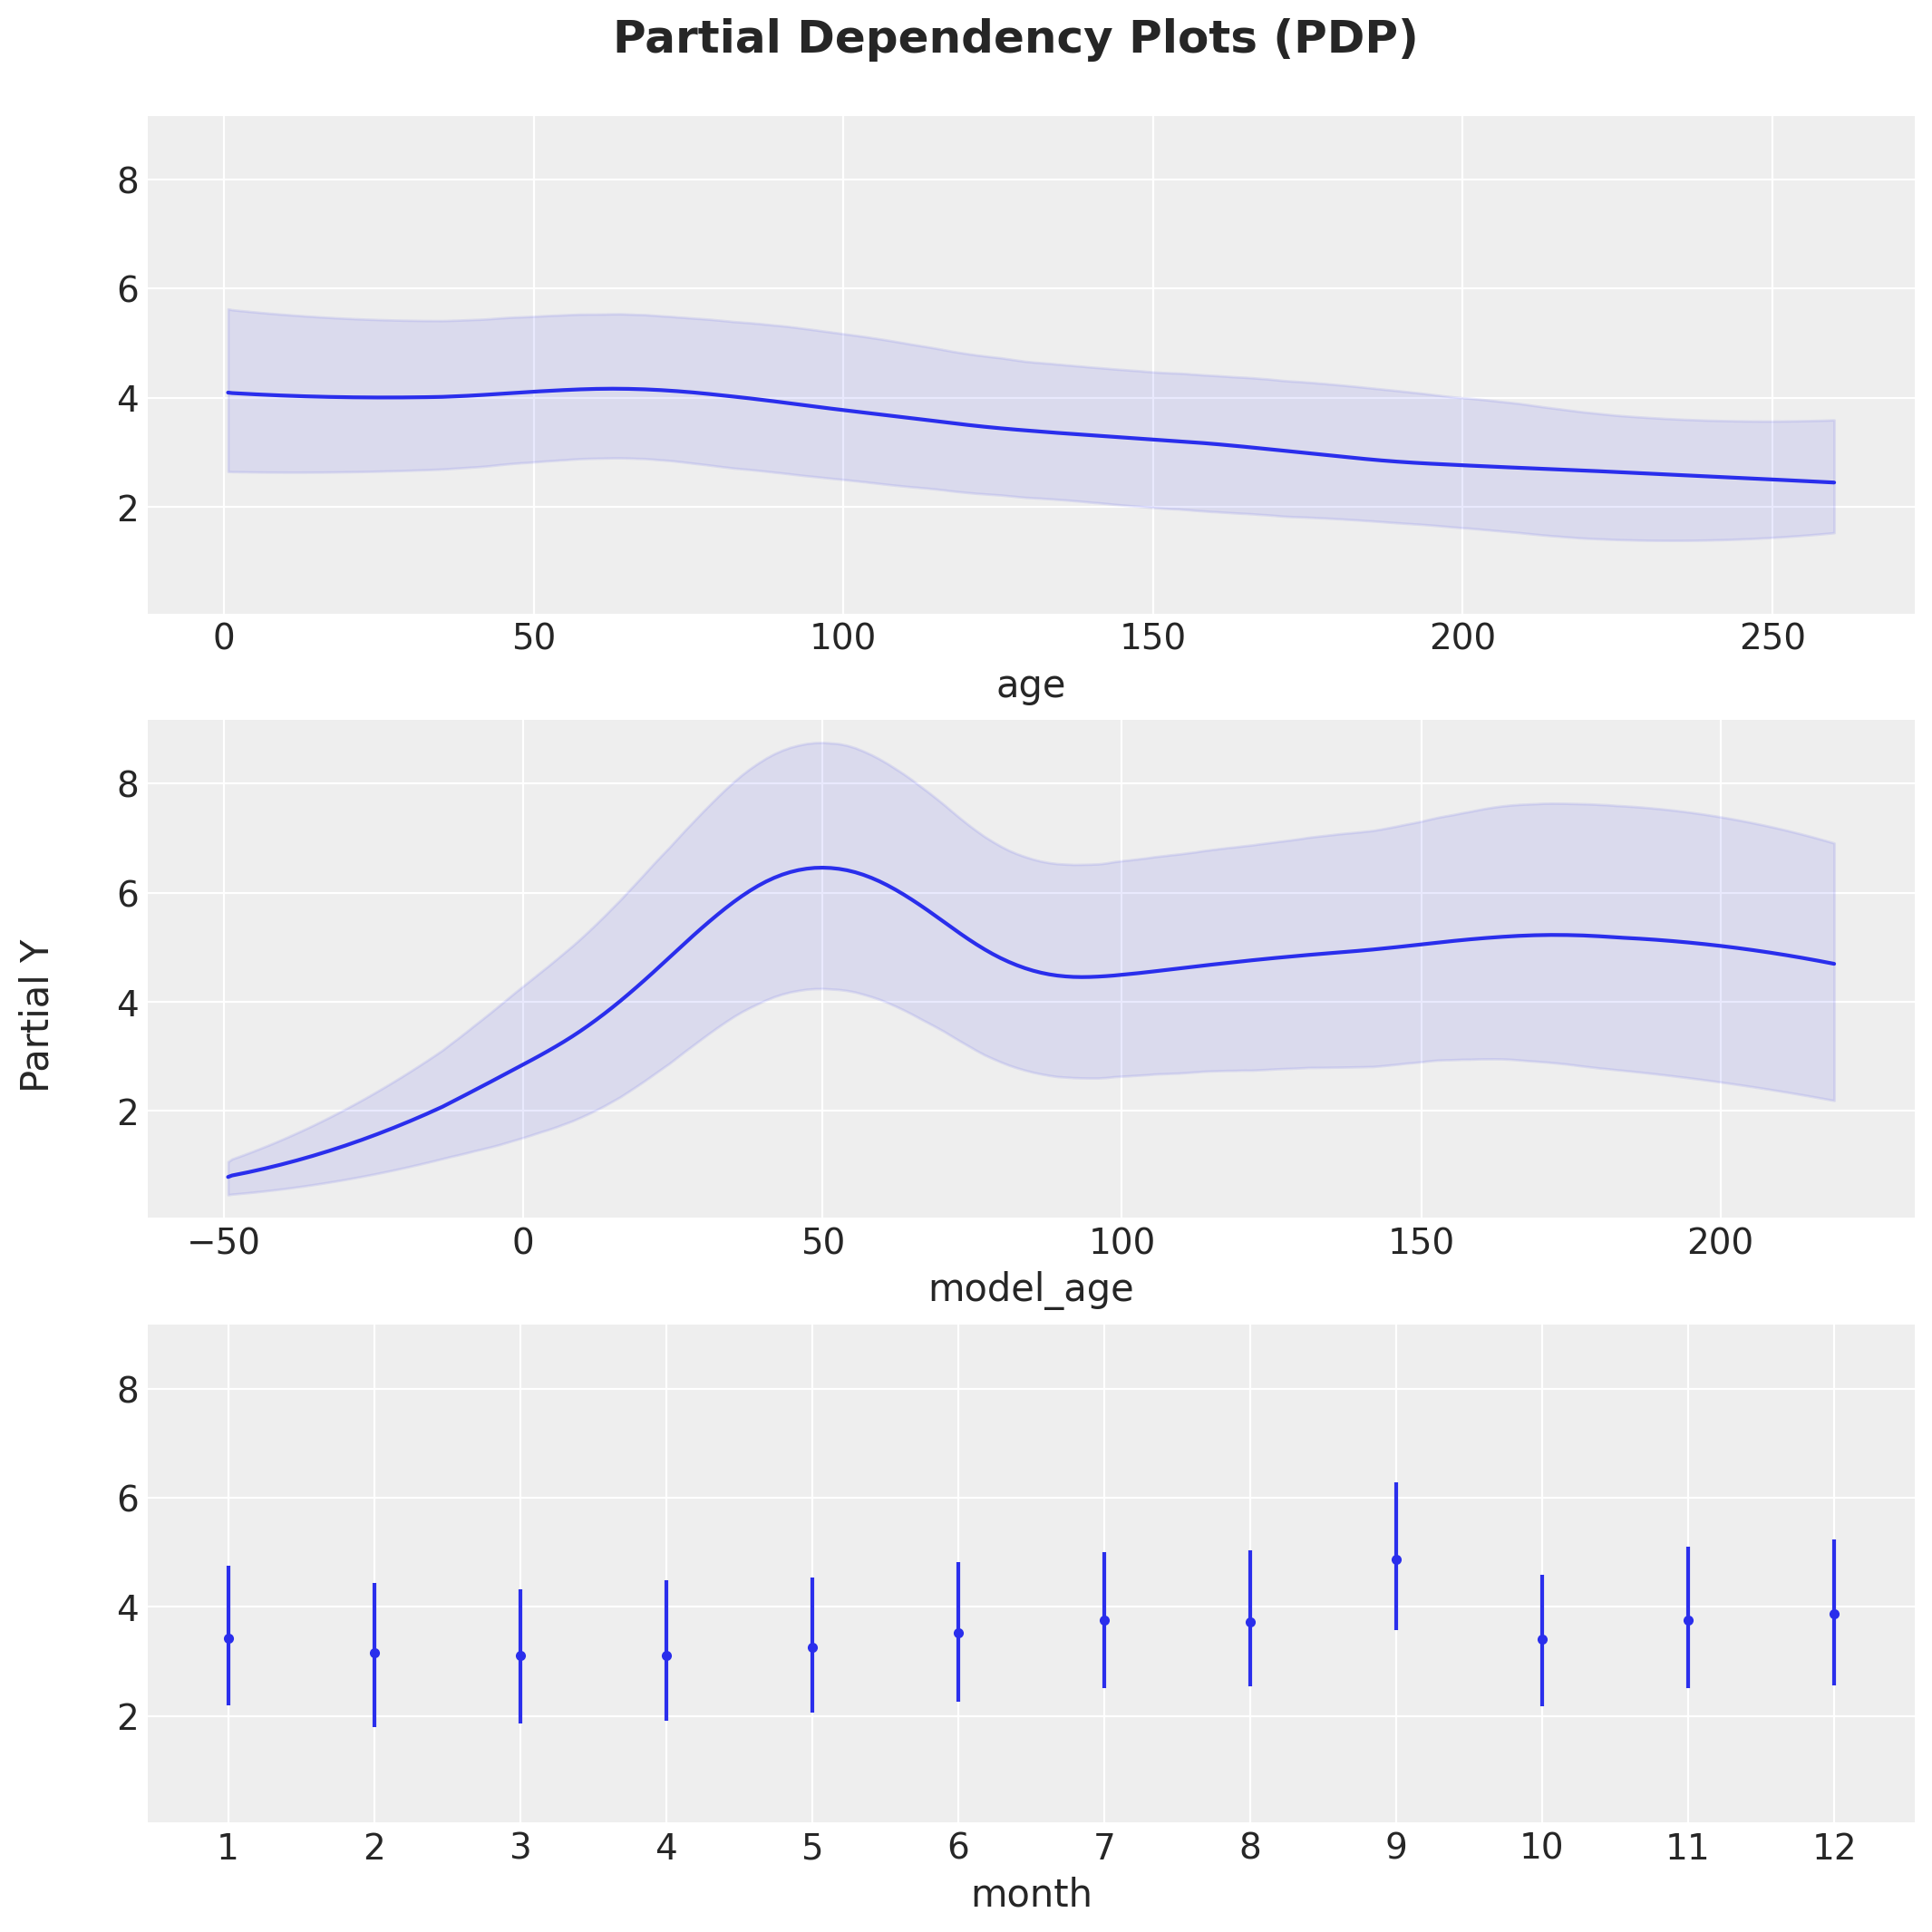

In [34]:
axes = pmb.plot_pdp(
    bartrv=bart_mu_log,
    X=x_train,
    Y=train_search,
    func=np.exp,
    xs_interval="insample",
    samples=1_000,
    grid="long",
    color="C0",
    color_mean="C0",
    var_discrete=[2],
    figsize=(10, 10),
    sharey=True,
    random_seed=seed,
)
plt.gcf().suptitle(
    "Partial Dependency Plots (PDP)",
    fontsize=18,
    fontweight="bold",
    y=1.05,
)

Text(0.5, 1.0, 'Google Trends for iPhone Models (Worldwide)')

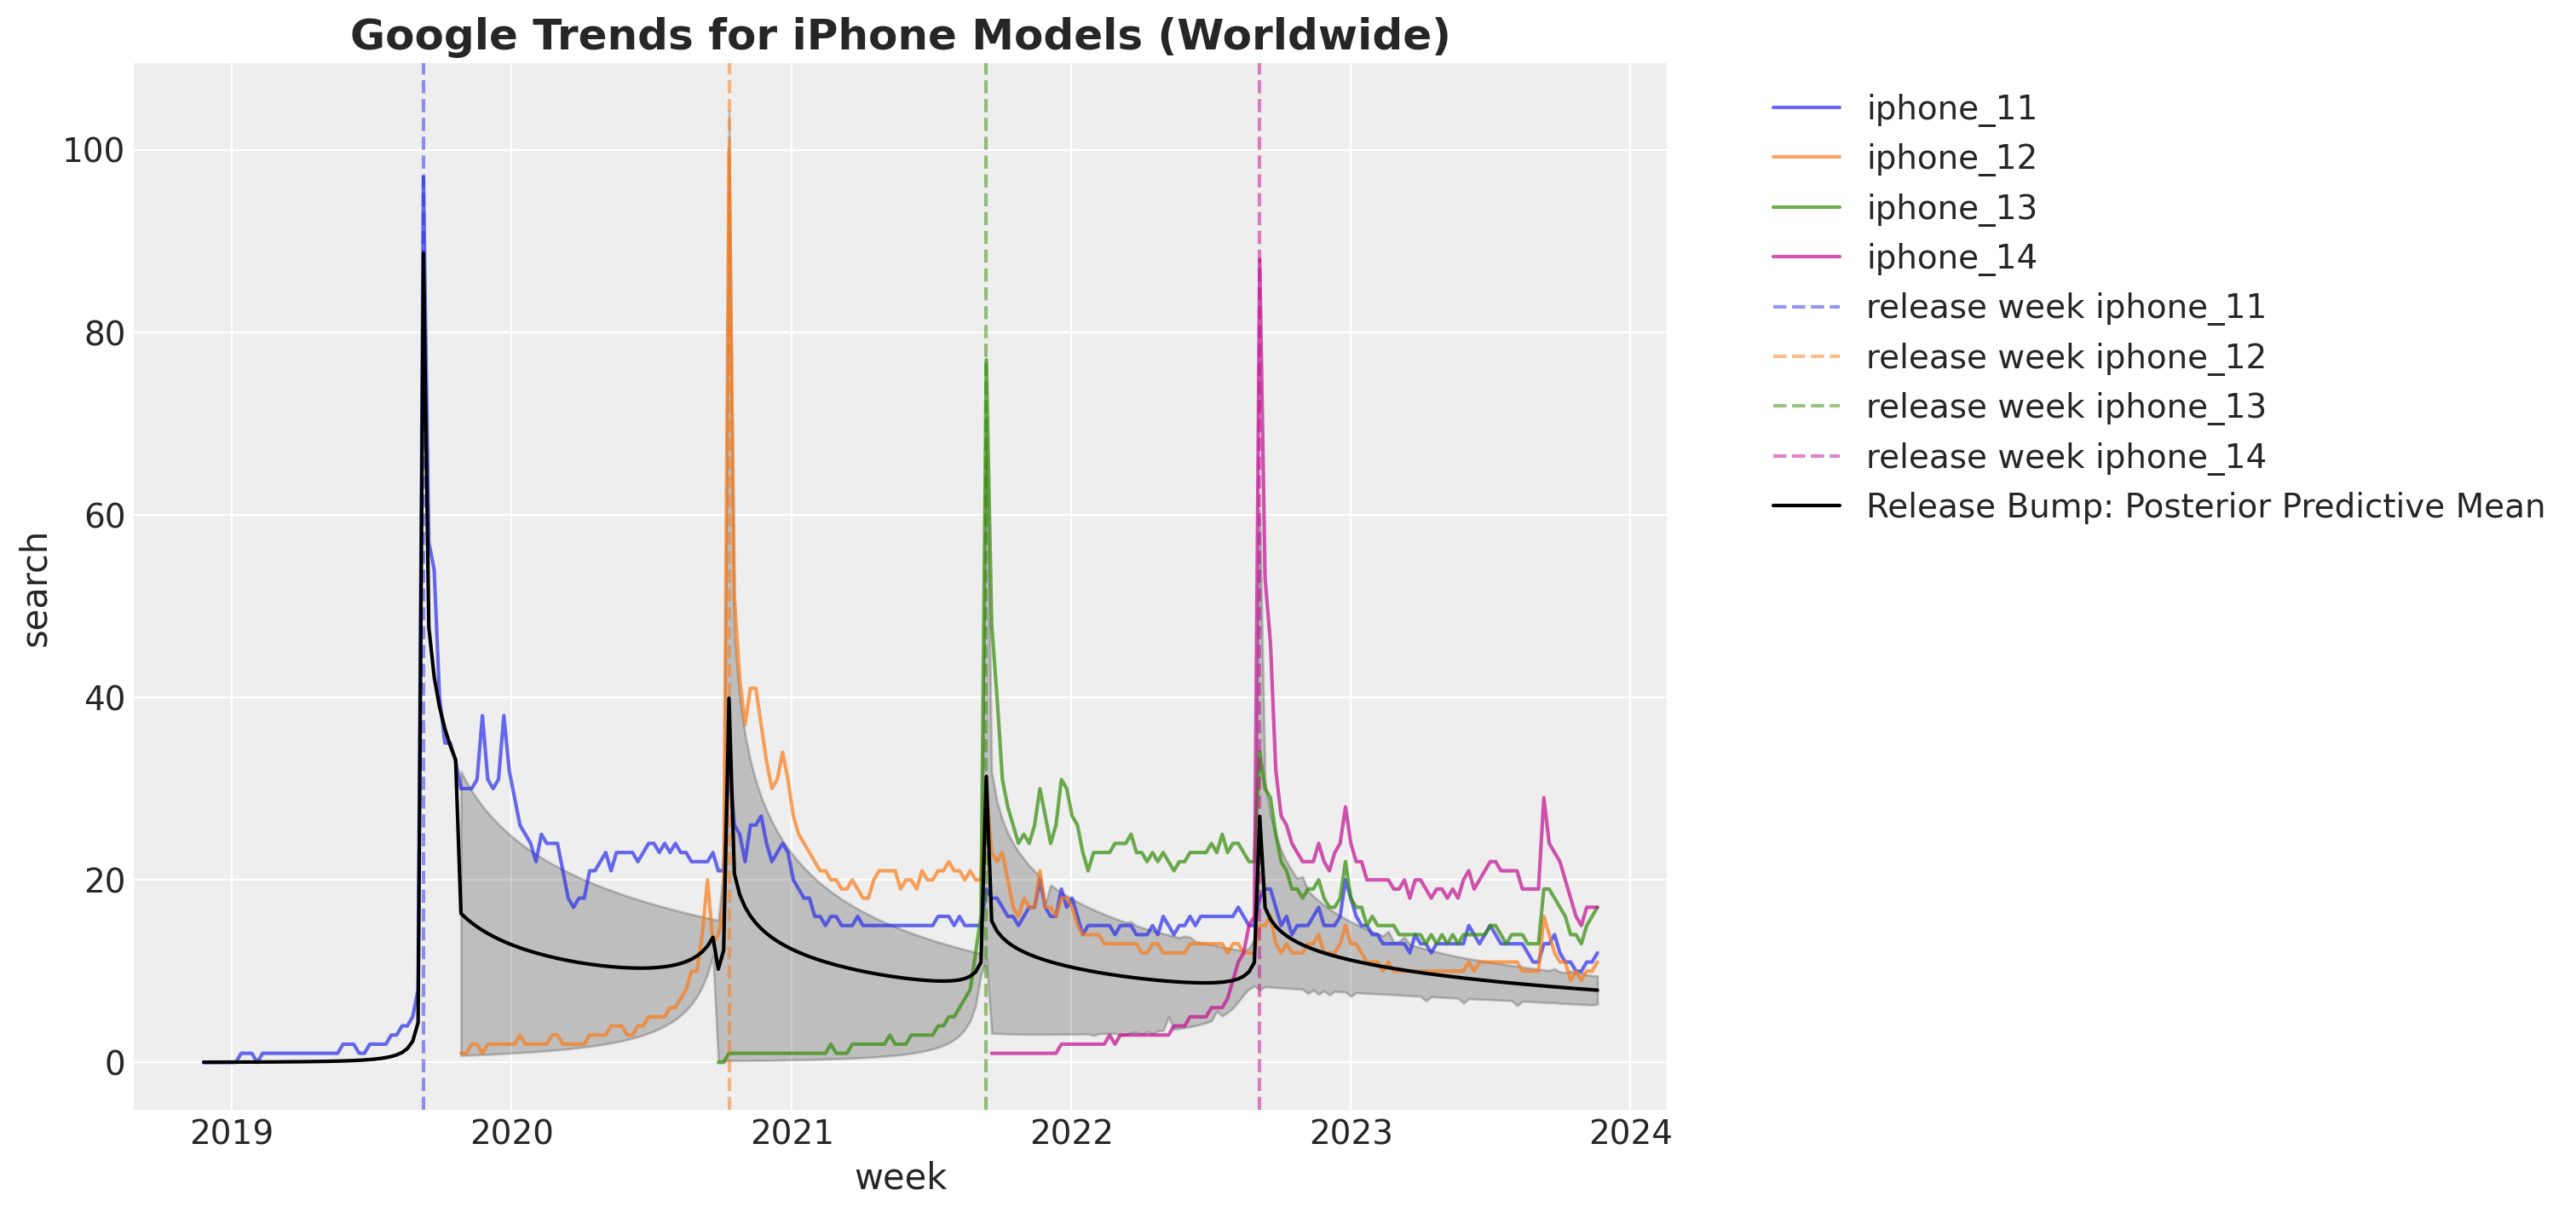

In [24]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.lineplot(
    data=train_df,
    x="week",
    y="search",
    hue="model",
    alpha=0.7,
    ax=ax,
)

for i, iphone_model in enumerate(
    release_dates_df.query(f"model != '{test_model}'")["model"]
):
    release_week = release_dates_df.query(f"model == '{iphone_model}'")[
        "release_week"
    ].item()
    ax.axvline(
        release_week,
        color=f"C{i}",
        linestyle="--",
        alpha=0.5,
        label=f"release week {iphone_model}",
    )

sns.lineplot(
    x=train_df["week"],
    y=idata["posterior"]["is_release_bump"].mean(dim=("chain", "draw")),
    color="black",
    label="Release Bump: Posterior Predictive Mean",
    ax=ax,
)

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_title(
    label="Google Trends for iPhone Models (Worldwide)", fontsize=18, fontweight="bold"
)

## Out-of-Sample Predictions

We now generate out of sample prediction for the unseen iPhone model:

In [25]:
test_obs = test_df.index.to_numpy()
test_iphone_model_idx, test_iphone_model = test_df["model"].factorize(sort=True)
test_month_idx, test_month = test_df["month"].factorize(sort=True)
test_age = test_df["age"].to_numpy()
test_model_age = test_df["model_age"].to_numpy()
test_is_release = test_df["is_release"].to_numpy()
x_test = test_df[["age", "model_age", "month"]]
test_search = test_df["search"].to_numpy()

In [26]:
with model:
    pm.set_data(
        new_data={
            "iphone_model_idx_data": test_iphone_model_idx,
            "model_age_data": test_model_age,
            "x_data": x_test,
            "search_data": np.ones_like(test_search),  # Dummy data to make coords work!
            # We are not using this at prediction time!
        },
        coords={"iphone_model": test_iphone_model, "obs": test_obs},
    )
    idata.extend(
        pm.sample_posterior_predictive(
            trace=idata,
            var_names=["is_release_bump", "mu", "likelihood"],
            idata_kwargs={
                "coords": {"iphone_model": test_iphone_model, "obs": test_obs}
            },
            random_seed=rng,
        )
    )

Sampling: [likelihood, mu_log]


[Text(0.5, 1.0, 'iphone_15'),
 Text(0.5, 0, 'Model Age (weeks)'),
 Text(0, 0.5, 'Search')]

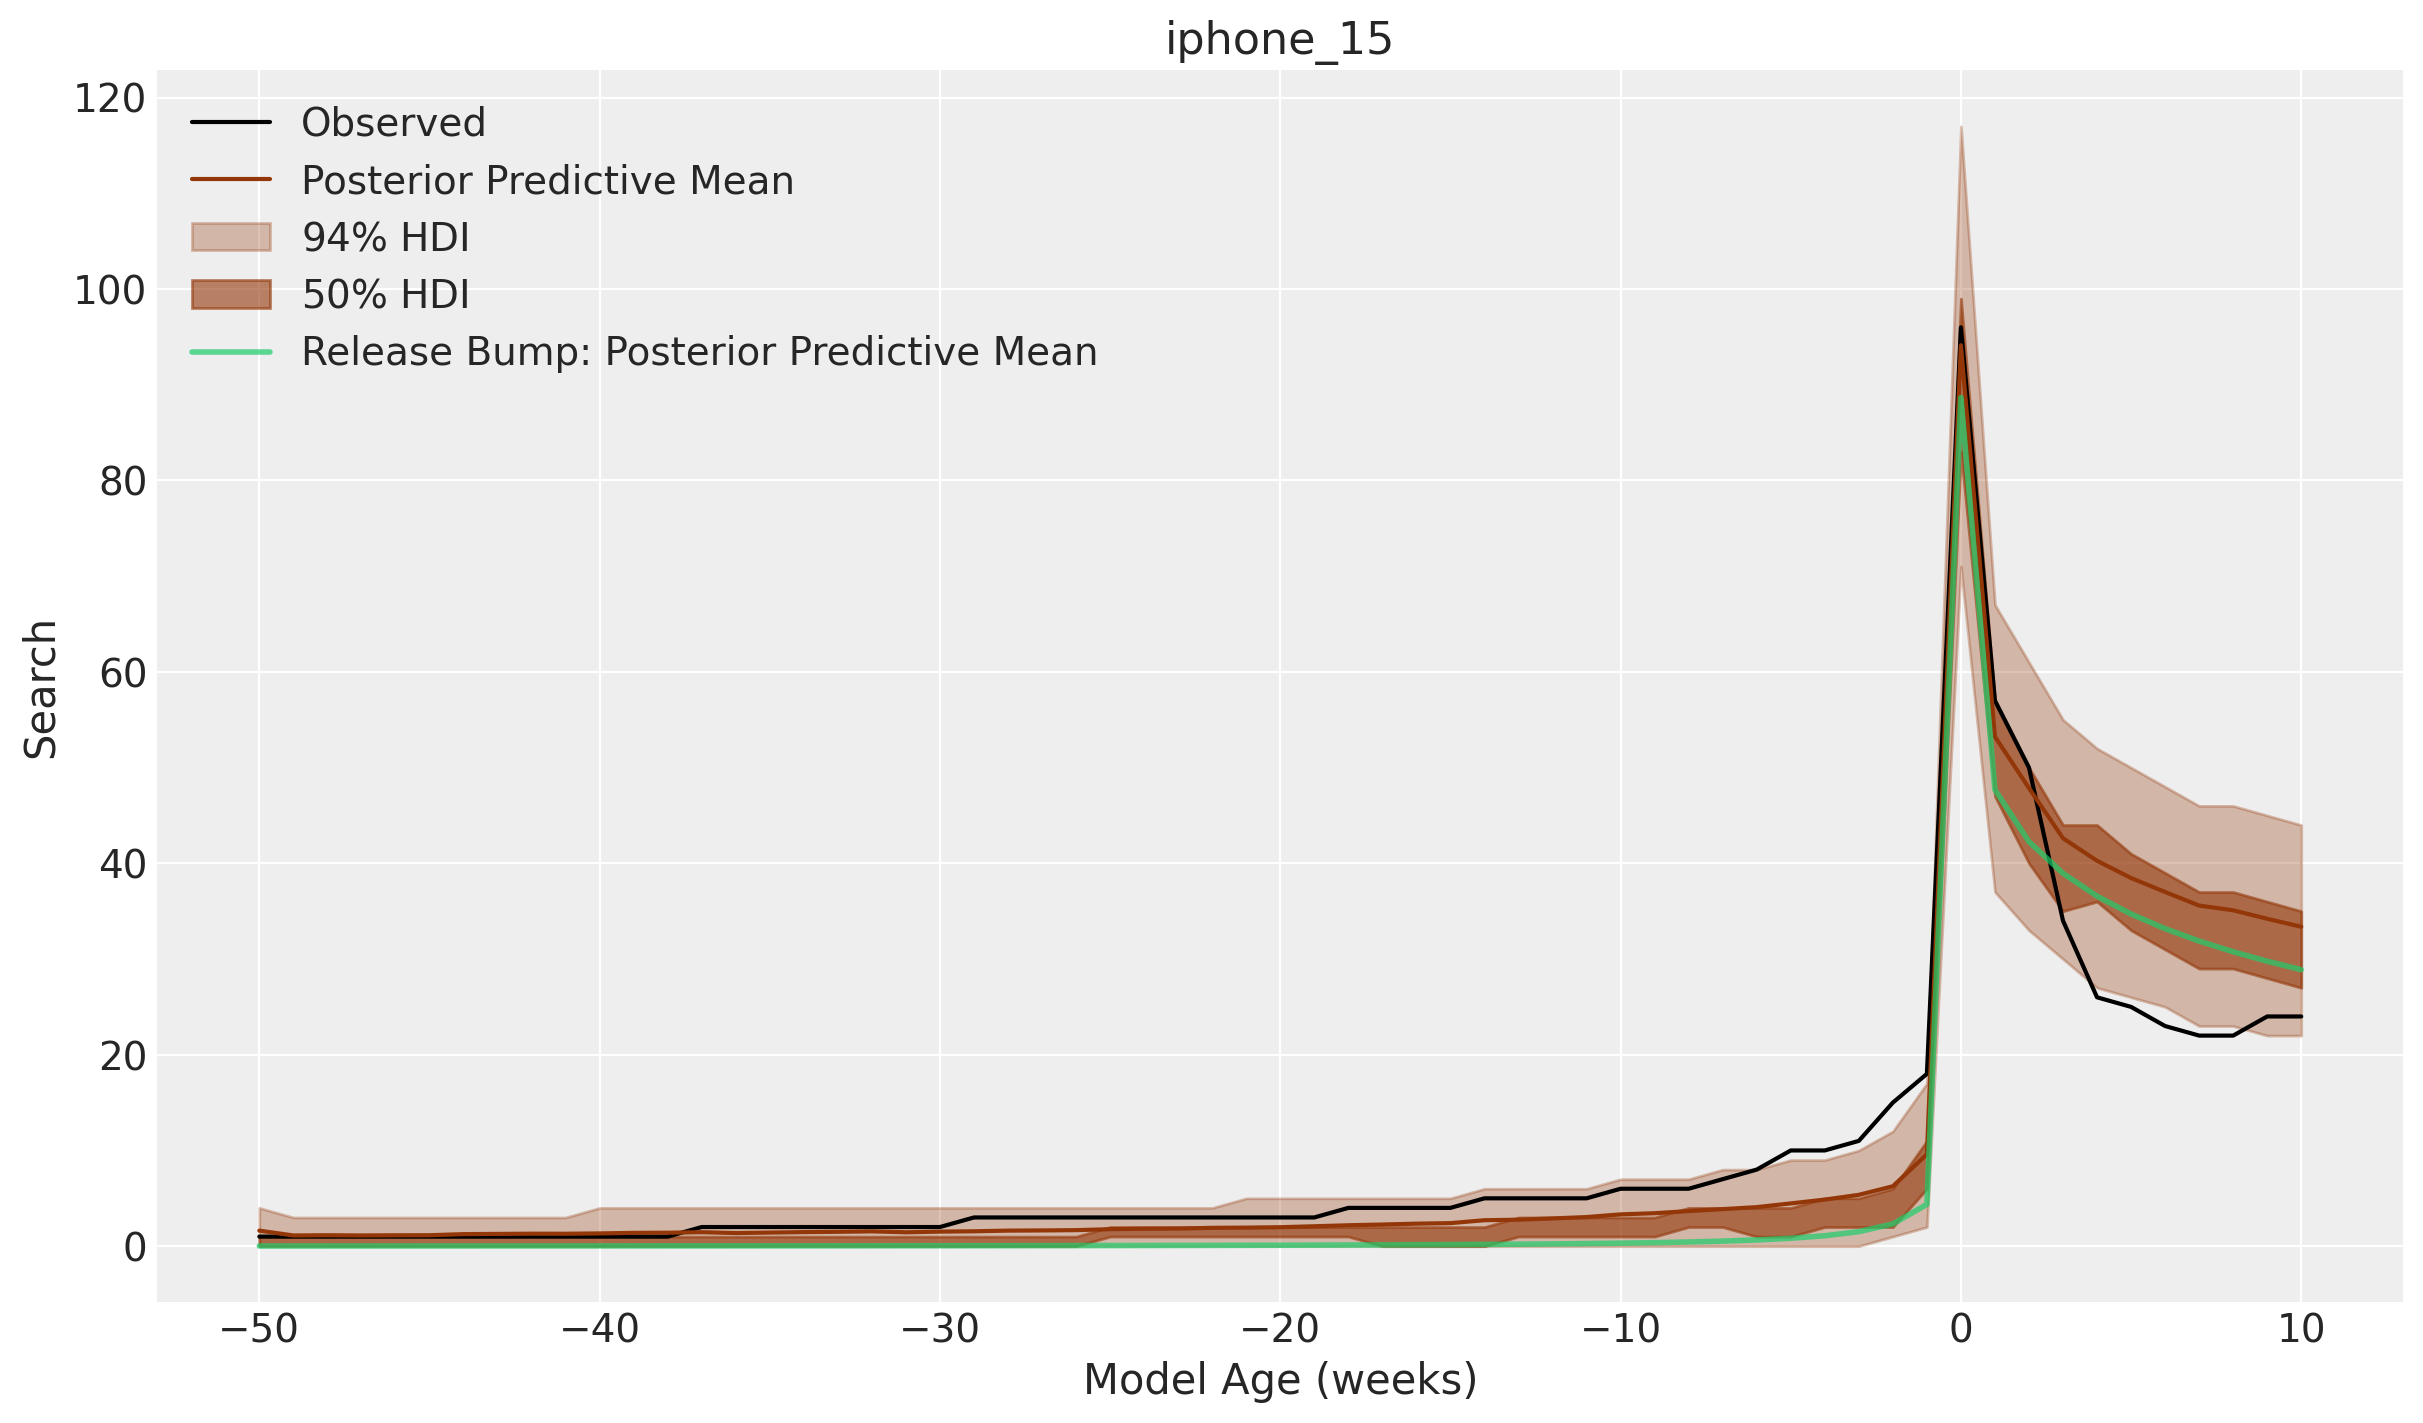

In [27]:
fig, ax = plt.subplots()


test_likelihood = idata["posterior_predictive"]["likelihood"]

i = 4

sns.lineplot(
    data=test_df,
    x="model_age",
    y="search",
    color="black",
    label="Observed",
    ax=ax,
)
sns.lineplot(
    x=test_df["model_age"],
    y=test_likelihood.mean(dim=("chain", "draw")),
    color=f"C{i}",
    label="Posterior Predictive Mean",
    ax=ax,
)
az.plot_hdi(
    x=test_df["model_age"],
    y=test_likelihood,
    hdi_prob=0.94,
    color=f"C{i}",
    smooth=False,
    fill_kwargs={"alpha": 0.3, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=test_df["model_age"],
    y=test_likelihood,
    hdi_prob=0.50,
    color=f"C{i}",
    smooth=False,
    fill_kwargs={"alpha": 0.6, "label": r"$50\%$ HDI"},
    ax=ax,
)
sns.lineplot(
    x=test_df["model_age"],
    y=idata["posterior_predictive"]["is_release_bump"].mean(dim=("chain", "draw")),
    color="C7",
    linewidth=2,
    alpha=0.7,
    label="Release Bump: Posterior Predictive Mean",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title=test_model, xlabel="Model Age (weeks)", ylabel="Search")